In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Data Preperation and Overview

In [3]:
df= pd.read_csv('data.csv')

In [4]:
df.head(5)

,Unnamed: 0,user_id,order_date,order_id,sku_id,warehouse_name,quantity,placed_gmv
0,0,0868733,2022-09-16,262052,2567941,USA,1.0,331.60
1,1,0868733,2022-09-16,262052,434572f,USA,1.0,416.52
2,2,0868733,2022-09-16,262052,8ae8fa4,USA,2.0,45.00
3,3,0868733,2022-09-16,262052,c9932dc,USA,3.0,67.50
4,4,0868733,2022-09-16,262052,35c7c3b,USA,1.0,340.71


In [5]:
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Unnamed: 0        0
user_id           0
order_date        0
order_id          0
sku_id            0
warehouse_name    0
quantity          0
placed_gmv        0
dtype: int64


In [6]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")


Number of duplicate rows: 0


In [7]:
# Check data types of each column
data_types = df.dtypes
print("Data types of columns:\n", data_types)

Data types of columns:
 Unnamed: 0          int64
user_id            object
order_date         object
order_id            int64
sku_id             object
warehouse_name     object
quantity          float64
placed_gmv        float64
dtype: object


In [8]:
for col in df.columns:
    print(col, df[col].nunique())

# df['warehouse_name'].value_counts()

Unnamed: 0 130000
user_id 3660
order_date 114
order_id 21139
sku_id 2488
warehouse_name 3
quantity 54
placed_gmv 20578


In [9]:
# Get basic summary statistics for numerical columns
summary_stats = df.describe()
summary_stats

,Unnamed: 0,order_id,quantity,placed_gmv
count,130000.000000,1.300000e+05,130000.000000,130000.000000
mean,64999.500000,6.822964e+05,1.591008,1336.445672
std,37527.911835,3.202138e+05,1.854480,2735.577056
min,0.000000,2.387230e+05,1.000000,4.200000
25%,32499.750000,3.236010e+05,1.000000,371.500000
50%,64999.500000,8.655470e+05,1.000000,591.900000
75%,97499.250000,9.787400e+05,2.000000,1310.490000
max,129999.000000,1.064487e+06,137.000000,216814.080000


## Convert order_date to datetime format

In [10]:
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

print(df.dtypes)


Unnamed: 0                 int64
user_id                   object
order_date        datetime64[ns]
order_id                   int64
sku_id                    object
warehouse_name            object
quantity                 float64
placed_gmv               float64
dtype: object


# Customer Behavior Analysis

## 1. Analysis costumer purchase Frequency

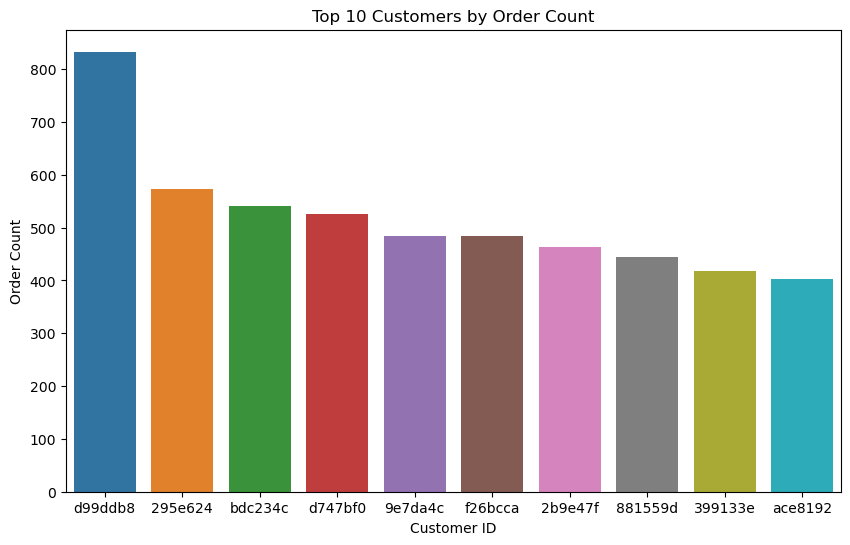

In [11]:
# Calculate the purchase frequency for each customer
purchase_frequency = df.groupby('user_id')['order_id'].count().reset_index().rename(columns={'order_id': 'order_count'})

# Sort customers by order count in descending order
purchase_frequency = purchase_frequency.sort_values(by='order_count', ascending=False)


purchase_frequency

# make plot for top 10 customers
plt.figure(figsize=(10, 6))
sns.barplot(x='user_id', y='order_count', data=purchase_frequency.head(10))
plt.title('Top 10 Customers by Order Count')
plt.xlabel('Customer ID')
plt.ylabel('Order Count')
plt.show()

In [12]:
purchase_frequency['order_count'].describe()

count    3660.000000
mean       35.519126
std        52.486606
min         1.000000
25%         7.000000
50%        17.000000
75%        43.000000
max       833.000000
Name: order_count, dtype: float64

In [13]:
# how many people are buying 100 times or more
purchase_frequency[purchase_frequency['order_count'] >= 100].shape[0]


293

## 2. Identify Top Customers by GMV and Order Frequency

In [14]:
# Calculate the total GMV for each customer
customer_gmv = df.groupby('user_id')['placed_gmv'].sum().reset_index()

# Sort customers by GMV in descending order
top_customers_gmv = customer_gmv.sort_values(by='placed_gmv', ascending=False)

top_customers_gmv

,user_id,placed_gmv
1878,864cd3a,1332258.05
2710,bdc234c,1184905.64
854,3d890d3,1088147.31
3113,d99ddb8,1077321.58
3487,f3c7b62,1063854.26
...,...,...
2280,a168f63,570.48
1843,83f0644,570.20
3060,d5b8121,519.65
2365,a740dd2,408.78


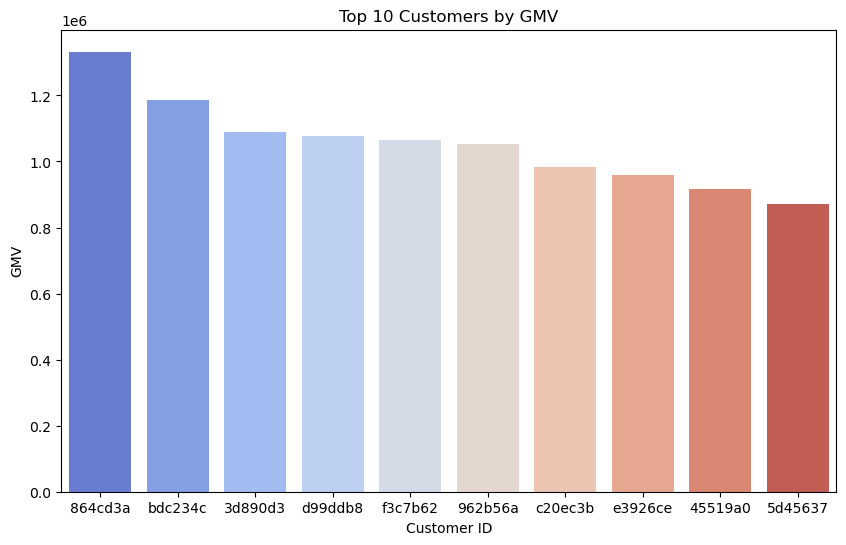

In [15]:
# make a plot for top 10 customers 
plt.figure(figsize=(10, 6))
sns.barplot(x='user_id', y='placed_gmv', data=top_customers_gmv.head(10), palette='coolwarm')
plt.title('Top 10 Customers by GMV')
plt.xlabel('Customer ID')
plt.ylabel('GMV')
plt.show()


In [16]:
top_customers_gmv['placed_gmv'].describe()

count    3.660000e+03
mean     4.746938e+04
std      9.835593e+04
min      2.804000e+02
25%      5.760060e+03
50%      1.589863e+04
75%      4.658797e+04
max      1.332258e+06
Name: placed_gmv, dtype: float64

In [17]:
# Sort customers by the number of orders placed
top_customers_frequency = purchase_frequency.head()

# Display top 5 customers by order frequency
print(top_customers_frequency)


      user_id  order_count
3113  d99ddb8          833
565   295e624          574
2710  bdc234c          541
3081  d747bf0          525
2227  9e7da4c          485


## 3. Segment Customers Based on RFM (Recency, Frequency, Monetary) Analysis
RFM analysis is a powerful way to segment customers based on their behavior.

Recency: When the customer last made a purchase.  
Frequency: How often the customer made purchases.  
Monetary: How much money the customer has spent.  

In [18]:
most_recent_date = df['order_date'].max()

# Calculate Recency
recency_df = df.groupby('user_id').agg({'order_date': lambda x: (most_recent_date - x.max()).days}).reset_index()
recency_df = recency_df.rename(columns={'order_date': 'recency'})

# Frequency: Number of orders placed by the customer
frequency_df = purchase_frequency.rename(columns={'order_count': 'frequency'})

# Monetary: Total GMV per customer
monetary_df = df.groupby('user_id').agg({'placed_gmv': 'sum'}).reset_index().rename(columns={'placed_gmv': 'monetary'})

# Merge recency, frequency, and monetary data
rfm_df = recency_df.merge(frequency_df, on='user_id').merge(monetary_df, on='user_id')

# Display the RFM table
print(rfm_df.head())


   user_id  recency  frequency  monetary
0  0000e88       67          3   9491.60
1  000159a       13         98  84908.69
2  000c1b2       23          3   5304.84
3  0039abd       12          3   2098.24
4  003b0e5       76          9   2525.84


In [19]:
#  make a new data frame with df and rfm_df
df_rfm = df.merge(rfm_df, on='user_id')

In [20]:
df_rfm.head()

,Unnamed: 0,user_id,order_date,order_id,sku_id,warehouse_name,quantity,placed_gmv,recency,frequency,monetary
0,0,0868733,2022-09-16,262052,2567941,USA,1.0,331.60,425,13,5065.73
1,1,0868733,2022-09-16,262052,434572f,USA,1.0,416.52,425,13,5065.73
2,2,0868733,2022-09-16,262052,8ae8fa4,USA,2.0,45.00,425,13,5065.73
3,3,0868733,2022-09-16,262052,c9932dc,USA,3.0,67.50,425,13,5065.73
4,4,0868733,2022-09-16,262052,35c7c3b,USA,1.0,340.71,425,13,5065.73


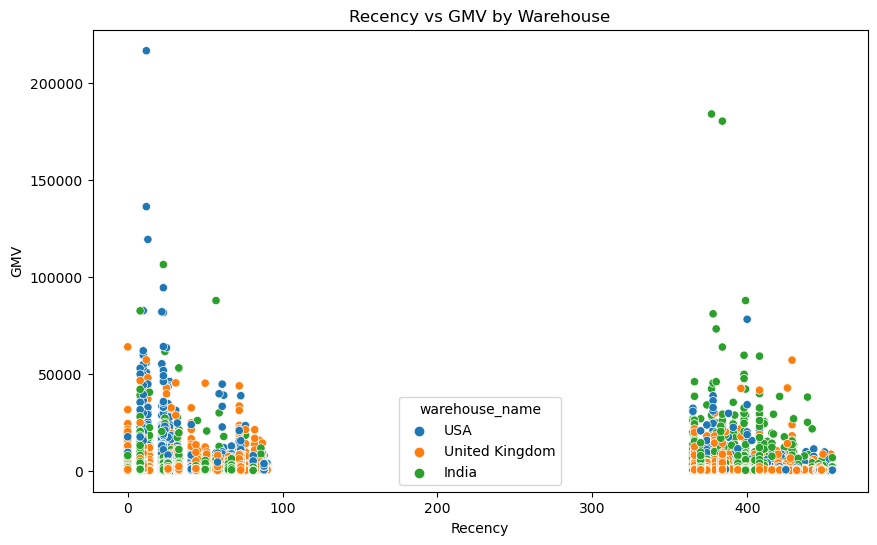

In [21]:
# make a plot for recency and hue by warehouse name

plt.figure(figsize=(10, 6))
sns.scatterplot(x='recency', y='placed_gmv', hue='warehouse_name', data=df_rfm)
plt.title('Recency vs GMV by Warehouse')
plt.xlabel('Recency')
plt.ylabel('GMV')
plt.show()

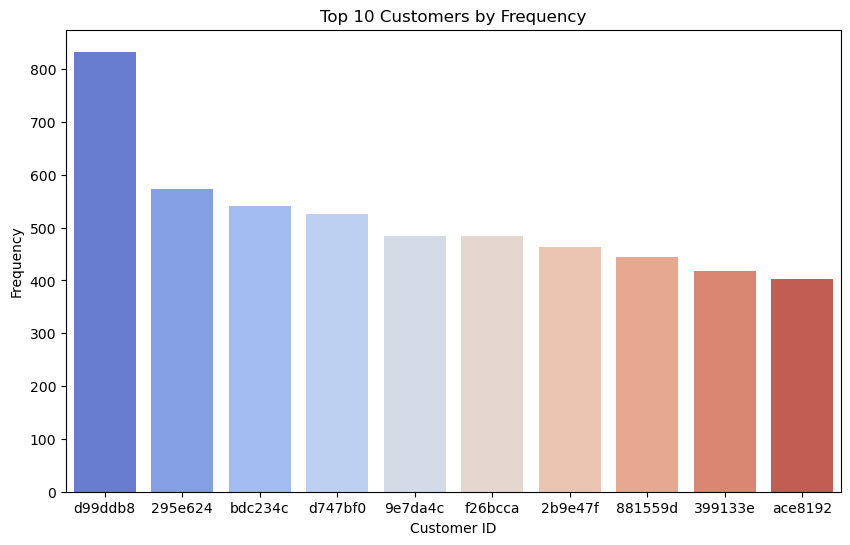

In [22]:
# plot top 10 customers by frequency
plt.figure(figsize=(10, 6))
sns.barplot(x='user_id', y='frequency', data=rfm_df.sort_values(by='frequency', ascending=False).head(10), palette='coolwarm')
plt.title('Top 10 Customers by Frequency')
plt.xlabel('Customer ID')
plt.ylabel('Frequency')
plt.show()

In [23]:
# similar plot for frequency and hue by warehouse name
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='frequency', y='value_per_item', hue='warehouse_name', data=df_rfm)
# plt.title('Frequency vs value_per_item by Warehouse')
# plt.xlabel('Frequency')
# plt.ylabel('value_per_item')
# plt.show()


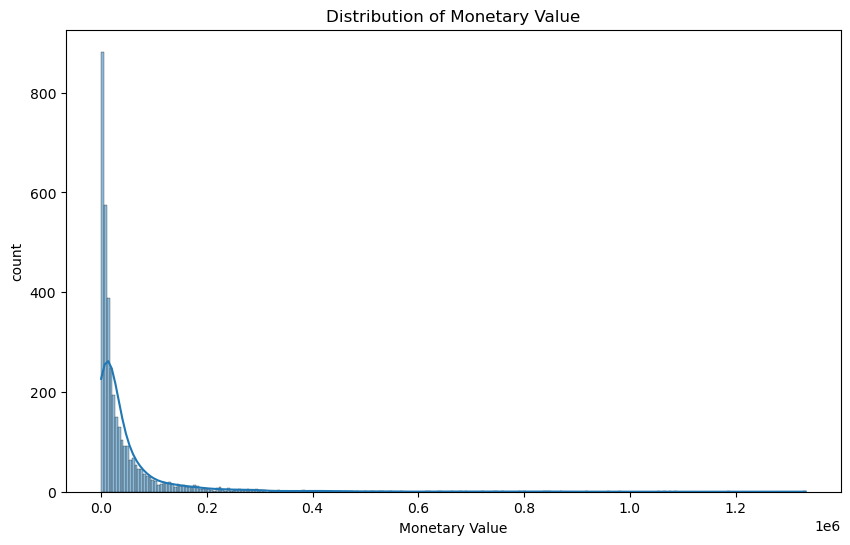

In [24]:
#  make a distribution plot for monetary and also show how 
plt.figure(figsize=(10, 6))
sns.histplot(rfm_df['monetary'], kde=True)
plt.title('Distribution of Monetary Value')
plt.xlabel('Monetary Value')
plt.ylabel('count')
plt.show()


In [25]:
# Standardize the RFM data
scaler = StandardScaler()
rfm_df_scaled = scaler.fit_transform(rfm_df[['recency', 'frequency', 'monetary']])
rfm_df_scaled = pd.DataFrame(rfm_df_scaled, columns=['recency', 'frequency', 'monetary'])   

# Display the scaled RFM data

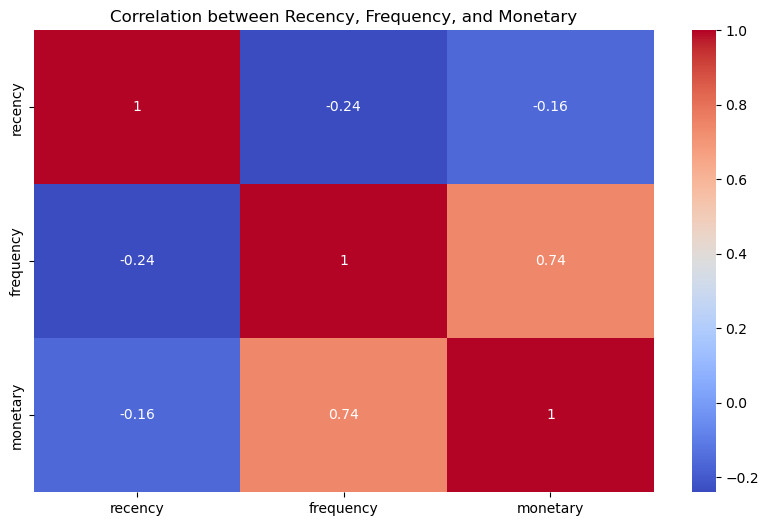

In [26]:
# make a heatmap to see the correlation between recency, frequency, and monetary
plt.figure(figsize=(10, 6))
sns.heatmap(df_rfm[['recency', 'frequency', 'monetary']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between Recency, Frequency, and Monetary')
plt.show()


b. RFM Segmentation
We can create a segmentation based on RFM by assigning scores (e.g., 1-5) for each metric:

In [27]:
# RFM Scoring (1 to 5)
rfm_df['recency_score'] = pd.qcut(rfm_df['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_df['frequency_score'] = pd.qcut(rfm_df['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm_df['monetary_score'] = pd.qcut(rfm_df['monetary'], 5, labels=[1, 2, 3, 4, 5])

# Calculate the overall RFM score
rfm_df['RFM_score'] = rfm_df['recency_score'].astype(str) + rfm_df['frequency_score'].astype(str) + rfm_df['monetary_score'].astype(str)

rfm_df.head()

,user_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score
0,0000e88,67,3,9491.60,2,1,2,212
1,000159a,13,98,84908.69,4,5,5,455
2,000c1b2,23,3,5304.84,4,1,2,412
3,0039abd,12,3,2098.24,4,1,1,411
4,003b0e5,76,9,2525.84,2,2,1,221


In [28]:
def segment_customer(row):
    if row['recency_score'] <= 2 and row['frequency_score'] >= 4 and row['monetary_score'] >= 4:
        return 'Champion'
    elif row['frequency_score'] >= 4 and row['monetary_score'] >= 4:
        return 'Loyal Customer'
    elif row['recency_score'] <= 2 and row['frequency_score'] >= 3:
        return 'Potential Loyalist'
    elif row['recency_score'] <= 2:
        return 'New Customer'
    elif row['recency_score'] >= 3 and row['frequency_score'] >= 2:
        return 'At Risk'
    else:
        return 'Lost'

# Apply segmentation
rfm_df['segment'] = rfm_df.apply(segment_customer, axis=1)

In [29]:
rfm_df.sample(10)

,user_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score,segment
3194,df68f0d,32,49,36046.56,3,4,4,344,Loyal Customer
2565,b45fc01,26,46,51111.67,3,4,4,344,Loyal Customer
2920,cc119fe,408,4,1970.70,1,1,1,111,New Customer
3476,f2f24c2,25,151,82947.53,3,5,5,355,Loyal Customer
2356,a6dec99,14,5,43376.64,4,1,4,414,Lost
2713,bdf79de,41,39,21858.79,3,4,3,343,At Risk
69,04cb8c2,453,14,5514.27,1,3,2,132,Potential Loyalist
453,2116543,370,27,16896.84,2,4,3,243,Potential Loyalist
17,00dda42,408,5,25390.88,1,1,4,114,New Customer
111,0796377,383,3,7820.16,1,1,2,112,New Customer


              segment  count
0      Loyal Customer    980
1             At Risk    955
2        New Customer    884
3  Potential Loyalist    396
4                Lost    280
5            Champion    165


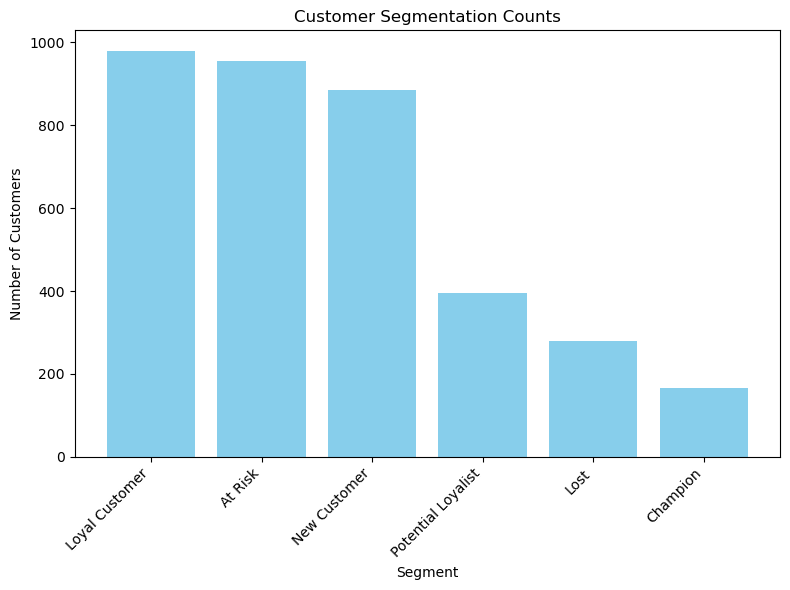

In [30]:
import matplotlib.pyplot as plt

# Assuming rfm_df is already loaded and contains a 'segment' column
# Count the number of users in each segment
segment_counts = rfm_df['segment'].value_counts().reset_index().rename(columns={'index': 'segment', 'segment': 'count'})
# Plot the segment counts
segment_counts.columns = ['segment', 'count']
print(segment_counts)
plt.figure(figsize=(8, 6))
plt.bar(segment_counts['segment'], segment_counts['count'], color='skyblue')
plt.title('Customer Segmentation Counts')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()



## 4. Examine Customer Retention and Churn Rates
For customer retention, we need to analyze how many customers are placing repeat orders and identify potential churn (customers who haven't ordered in a long time).

a. Customer Retention Rate

In [31]:
# Identify repeat customers
repeat_customers = df.groupby('user_id')['order_id'].nunique().reset_index()
repeat_customers['is_repeat'] = repeat_customers['order_id'] > 1

# Calculate retention rate
retention_rate = repeat_customers['is_repeat'].mean() * 100
print(f"Customer Retention Rate: {retention_rate:.2f}%")


Customer Retention Rate: 74.56%


b. Customer Churn Rate
You can calculate churn based on customers who haven't made a purchase recently, compared to the total customer base.

In [32]:
# Assume customers who have not purchased in the last 90 days are considered "churned"
churn_threshold_days = 90
churned_customers = rfm_df[rfm_df['recency'] > churn_threshold_days]

# Churn rate calculation
churn_rate = len(churned_customers) / len(rfm_df) * 100
print(f"Customer Churn Rate: {churn_rate:.2f}%")


Customer Churn Rate: 27.60%


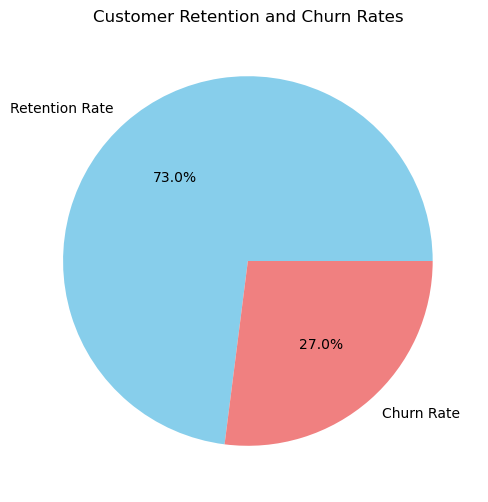

In [33]:
# pie chart for churn rate and retention rate
plt.figure(figsize=(8, 6))
plt.pie([retention_rate, churn_rate], labels=['Retention Rate', 'Churn Rate'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Customer Retention and Churn Rates')
plt.show()

# Sales Trends Analysis

### 1. Analyze Daily, Weekly, and Monthly Sales Trends  

a. Daily Sales Trends
We will group the dataset by order_date to analyze daily trends.

In [34]:
df.head()

,Unnamed: 0,user_id,order_date,order_id,sku_id,warehouse_name,quantity,placed_gmv
0,0,0868733,2022-09-16,262052,2567941,USA,1.0,331.60
1,1,0868733,2022-09-16,262052,434572f,USA,1.0,416.52
2,2,0868733,2022-09-16,262052,8ae8fa4,USA,2.0,45.00
3,3,0868733,2022-09-16,262052,c9932dc,USA,3.0,67.50
4,4,0868733,2022-09-16,262052,35c7c3b,USA,1.0,340.71


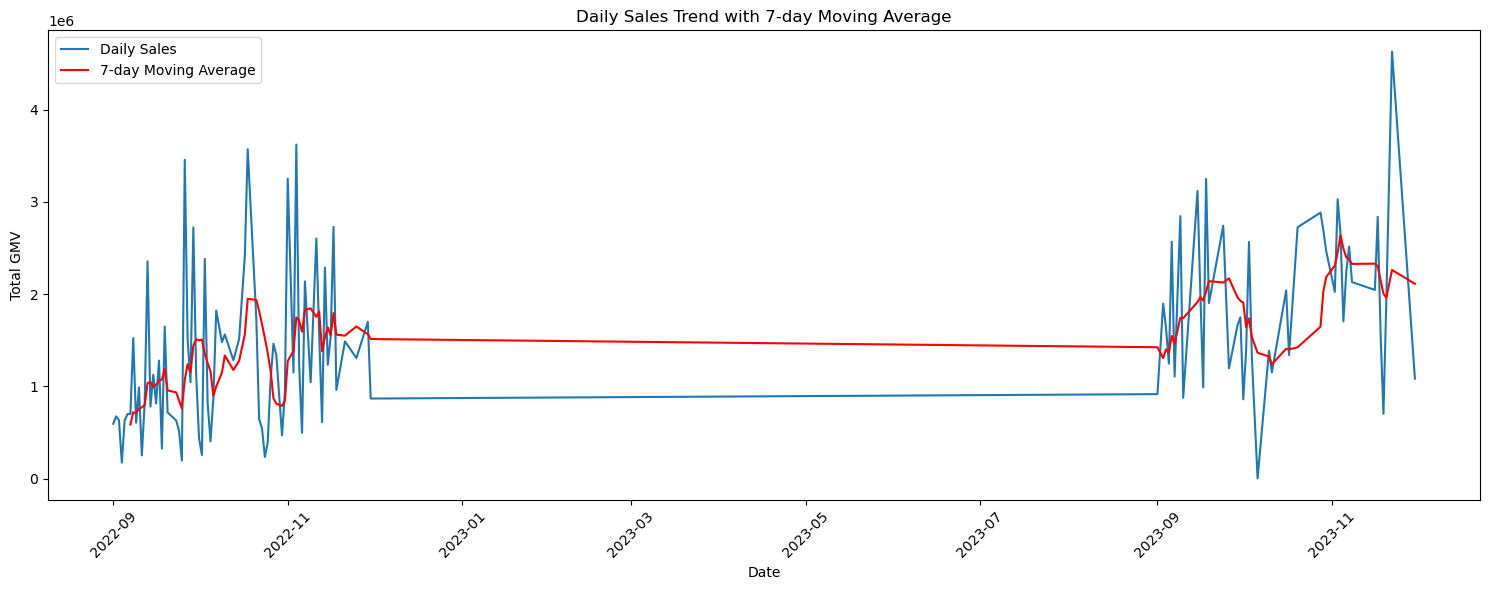

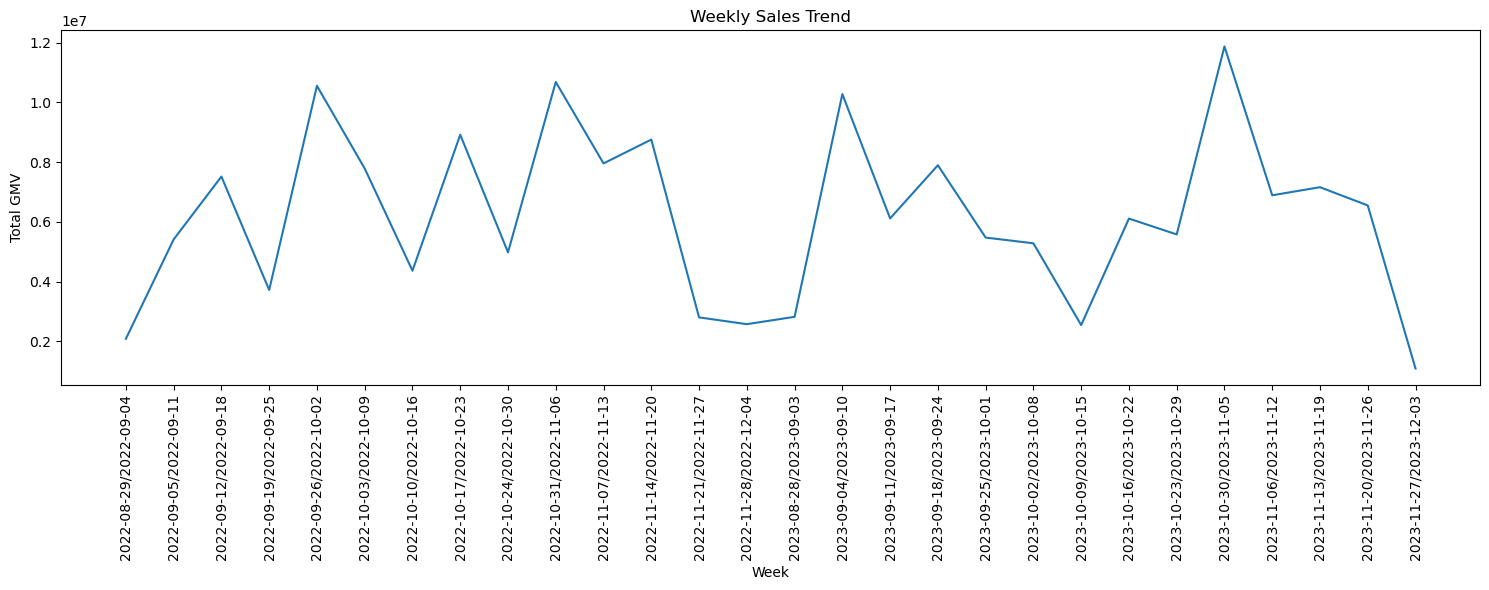

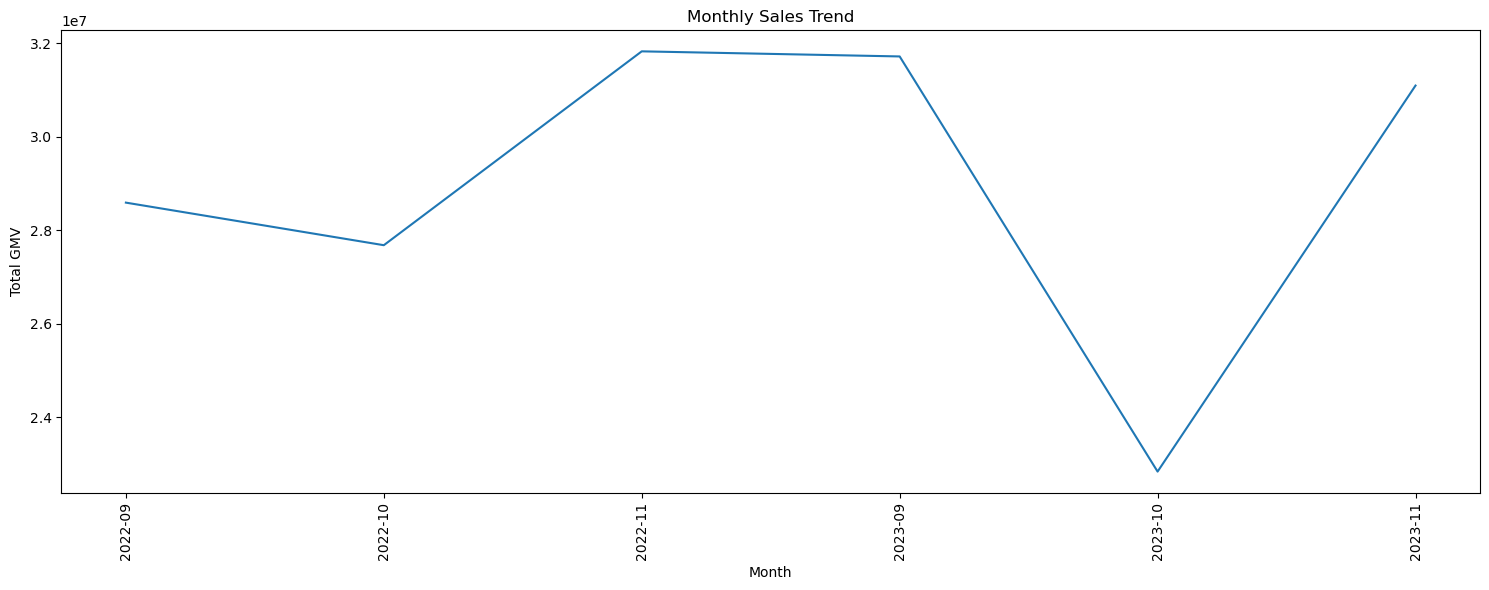

Daily Sales Summary:
count    1.140000e+02
mean     1.524017e+06
std      9.138745e+05
min      3.524530e+03
25%      8.218500e+05
50%      1.340766e+06
75%      2.110684e+06
max      4.629566e+06
Name: placed_gmv, dtype: float64

Weekly Sales Summary:
count    2.800000e+01
mean     6.204926e+06
std      2.853387e+06
min      1.084673e+06
25%      4.200678e+06
50%      6.111297e+06
75%      7.910988e+06
max      1.187747e+07
Name: placed_gmv, dtype: float64

Monthly Sales Summary:
count    6.000000e+00
mean     2.895632e+07
std      3.454953e+06
min      2.283371e+07
25%      2.790569e+07
50%      2.984150e+07
75%      3.156134e+07
max      3.182618e+07
Name: placed_gmv, dtype: float64


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Assuming the data is already loaded into a DataFrame called 'df'
# and 'order_date' is converted to datetime

# Daily sales trend
daily_sales = df.groupby('order_date')['placed_gmv'].sum().reset_index()
daily_sales['7_day_MA'] = daily_sales['placed_gmv'].rolling(window=7).mean()

plt.figure(figsize=(15, 6))
plt.plot(daily_sales['order_date'], daily_sales['placed_gmv'], label='Daily Sales')
plt.plot(daily_sales['order_date'], daily_sales['7_day_MA'], label='7-day Moving Average', color='red')
plt.title('Daily Sales Trend with 7-day Moving Average')
plt.xlabel('Date')
plt.ylabel('Total GMV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Weekly sales trend
df['Week'] = df['order_date'].dt.to_period('W')
weekly_sales = df.groupby('Week')['placed_gmv'].sum().reset_index()
weekly_sales['Week'] = weekly_sales['Week'].astype(str)

plt.figure(figsize=(15, 6))
plt.plot(weekly_sales['Week'], weekly_sales['placed_gmv'])
plt.title('Weekly Sales Trend')
plt.xlabel('Week')
plt.ylabel('Total GMV')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Monthly sales trend
df['Month'] = df['order_date'].dt.to_period('M')
monthly_sales = df.groupby('Month')['placed_gmv'].sum().reset_index()
monthly_sales['Month'] = monthly_sales['Month'].astype(str)

plt.figure(figsize=(15, 6))
plt.plot(monthly_sales['Month'], monthly_sales['placed_gmv'])
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total GMV')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Print summary statistics
print("Daily Sales Summary:")
print(daily_sales['placed_gmv'].describe())
print("\nWeekly Sales Summary:")
print(weekly_sales['placed_gmv'].describe())
print("\nMonthly Sales Summary:")
print(monthly_sales['placed_gmv'].describe())

## 2. Identify Peak Sales Periods and Seasonality
You can use the monthly or weekly sales trends to identify periods of high sales.

Top 10 Peak Sales Days:
    order_date  placed_gmv
112 2023-11-22  4629566.36
53  2022-11-04  3623119.11
40  2022-10-18  3572387.45
23  2022-09-26  3457606.77
51  2022-11-01  3252048.05
81  2023-09-18  3250288.29
78  2023-09-15  3120405.10
101 2023-11-03  3030412.93
97  2023-10-28  2885263.97
76  2023-09-09  2846904.68

Top 10 Peak Sales Weeks:
                     Week   placed_gmv
23  2023-10-30/2023-11-05  11877473.08
9   2022-10-31/2022-11-06  10685698.73
4   2022-09-26/2022-10-02  10557566.61
15  2023-09-04/2023-09-10  10280051.70
7   2022-10-17/2022-10-23   8919020.51
11  2022-11-14/2022-11-20   8756086.30
10  2022-11-07/2022-11-13   7956940.37
17  2023-09-18/2023-09-24   7895670.74
5   2022-10-03/2022-10-09   7787362.60
2   2022-09-12/2022-09-18   7517063.73

Top 10 Peak Sales Months:
     Month   placed_gmv
2  2022-11  31826184.02
3  2023-09  31717114.58
5  2023-11  31094024.46
0  2022-09  28588980.49
1  2022-10  27677926.44
4  2023-10  22833707.32


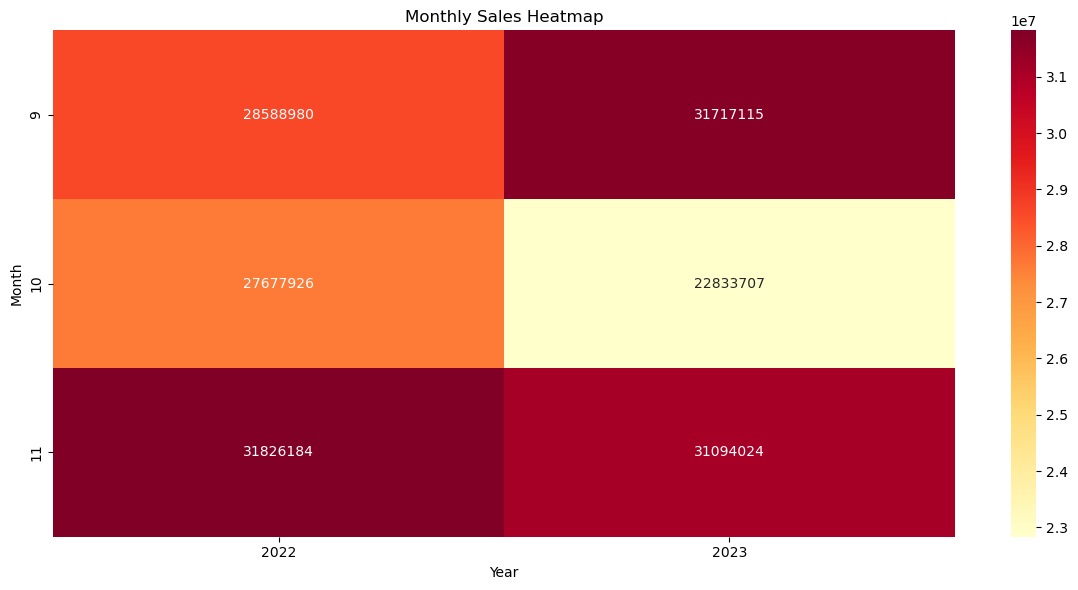

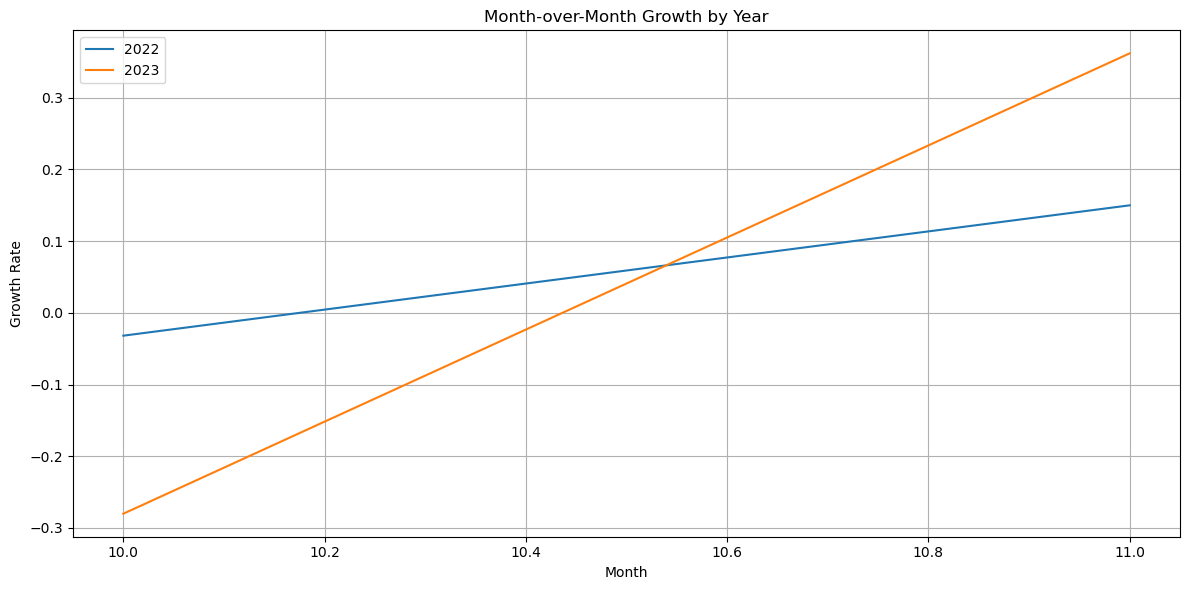

In [36]:
# 2. Identify peak sales periods and seasonality
# Peak sales periods
peak_daily = daily_sales.nlargest(10, 'placed_gmv')
peak_weekly = weekly_sales.nlargest(10, 'placed_gmv')
peak_monthly = monthly_sales.nlargest(10, 'placed_gmv')

print("Top 10 Peak Sales Days:")
print(peak_daily[['order_date', 'placed_gmv']])
print("\nTop 10 Peak Sales Weeks:")
print(peak_weekly[['Week', 'placed_gmv']])
print("\nTop 10 Peak Sales Months:")
print(peak_monthly[['Month', 'placed_gmv']])

# Seasonality analysis
df['Month'] = df['order_date'].dt.month
df['Year'] = df['order_date'].dt.year

monthly_seasonal = df.groupby(['Year', 'Month'])['placed_gmv'].sum().reset_index()
monthly_seasonal_pivot = monthly_seasonal.pivot(index='Month', columns='Year', values='placed_gmv')

plt.figure(figsize=(12, 6))
sns.heatmap(monthly_seasonal_pivot, cmap='YlOrRd', annot=True, fmt='.0f')
plt.title('Monthly Sales Heatmap')
plt.xlabel('Year')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

# Calculate month-over-month growth
monthly_seasonal['MoM_Growth'] = monthly_seasonal.groupby('Year')['placed_gmv'].pct_change()

plt.figure(figsize=(12, 6))
for year in monthly_seasonal['Year'].unique():
    year_data = monthly_seasonal[monthly_seasonal['Year'] == year]
    plt.plot(year_data['Month'], year_data['MoM_Growth'], label=str(year))

plt.title('Month-over-Month Growth by Year')
plt.xlabel('Month')
plt.ylabel('Growth Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
# Identify top 5 peak sales periods
peak_sales_periods = monthly_sales.sort_values(by='placed_gmv', ascending=False).head(5)
print("Top 5 Peak Sales Periods:\n", peak_sales_periods)

Top 5 Peak Sales Periods:
      Month   placed_gmv
2  2022-11  31826184.02
3  2023-09  31717114.58
5  2023-11  31094024.46
0  2022-09  28588980.49
1  2022-10  27677926.44


## 3. Calculate and Visualize Year-over-Year (YoY) Growth
To calculate year-over-year growth, we need to compare sales for each year.

In [38]:
df.head()

,Unnamed: 0,user_id,order_date,order_id,sku_id,warehouse_name,quantity,placed_gmv,Week,Month,Year
0,0,0868733,2022-09-16,262052,2567941,USA,1.0,331.60,2022-09-12/2022-09-18,9,2022
1,1,0868733,2022-09-16,262052,434572f,USA,1.0,416.52,2022-09-12/2022-09-18,9,2022
2,2,0868733,2022-09-16,262052,8ae8fa4,USA,2.0,45.00,2022-09-12/2022-09-18,9,2022
3,3,0868733,2022-09-16,262052,c9932dc,USA,3.0,67.50,2022-09-12/2022-09-18,9,2022
4,4,0868733,2022-09-16,262052,35c7c3b,USA,1.0,340.71,2022-09-12/2022-09-18,9,2022


posx and posy should be finite values
posx and posy should be finite values


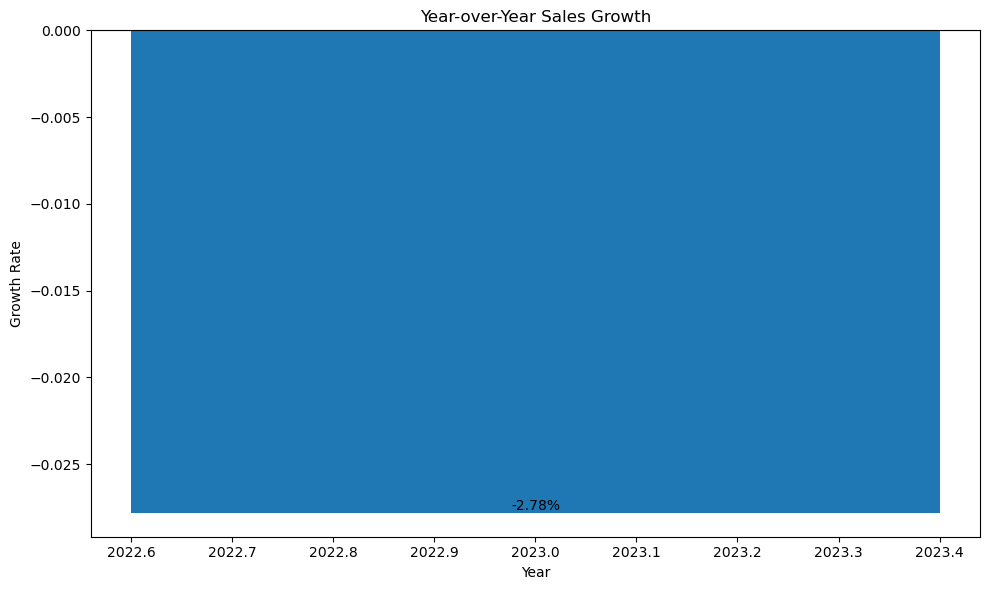

posx and posy should be finite values
posx and posy should be finite values


Yearly Sales and Growth:
   Year   placed_gmv  YoY_Growth
0  2022  88093090.95         NaN
1  2023  85644846.36   -0.027792


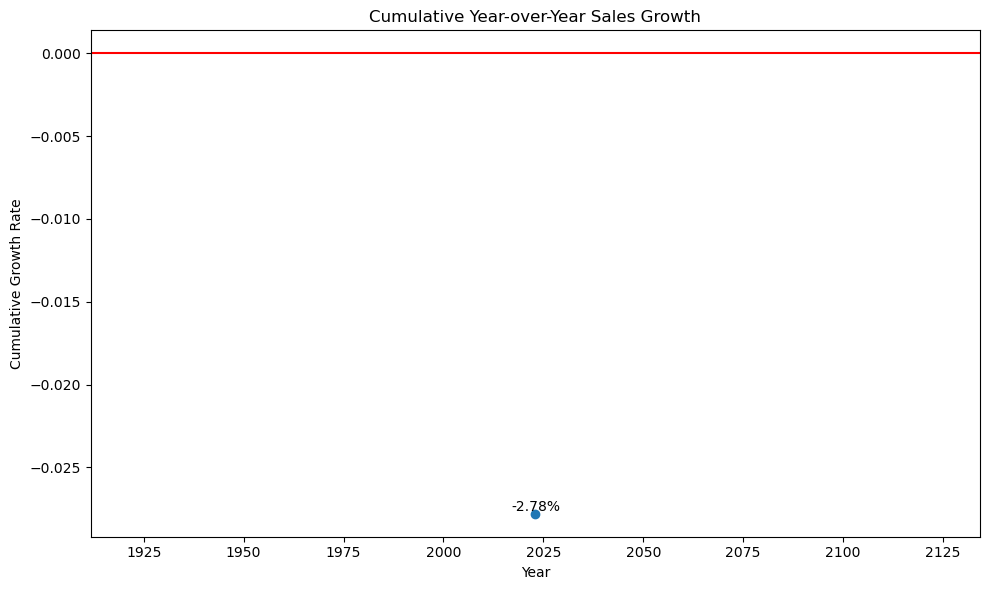

Yearly Sales and Cumulative Growth:
   Year   placed_gmv  YoY_Growth  Cumulative_Growth
0  2022  88093090.95         NaN                NaN
1  2023  85644846.36   -0.027792          -0.027792


In [39]:
# 3. Calculate and visualize year-over-year growth
yearly_sales = df.groupby('Year')['placed_gmv'].sum().reset_index()
yearly_sales['YoY_Growth'] = yearly_sales['placed_gmv'].pct_change()

plt.figure(figsize=(10, 6))
plt.bar(yearly_sales['Year'], yearly_sales['YoY_Growth'])
plt.title('Year-over-Year Sales Growth')
plt.xlabel('Year')
plt.ylabel('Growth Rate')
plt.axhline(y=0, color='r', linestyle='-')
for i, v in enumerate(yearly_sales['YoY_Growth']):
    plt.text(yearly_sales['Year'][i], v, f'{v:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

print("Yearly Sales and Growth:")
print(yearly_sales)

# Calculate and visualize cumulative year-over-year growth
yearly_sales['Cumulative_Growth'] = (1 + yearly_sales['YoY_Growth']).cumprod() - 1

plt.figure(figsize=(10, 6))
plt.plot(yearly_sales['Year'], yearly_sales['Cumulative_Growth'], marker='o')
plt.title('Cumulative Year-over-Year Sales Growth')
plt.xlabel('Year')
plt.ylabel('Cumulative Growth Rate')
plt.axhline(y=0, color='r', linestyle='-')
for i, v in enumerate(yearly_sales['Cumulative_Growth']):
    plt.text(yearly_sales['Year'][i], v, f'{v:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

print("Yearly Sales and Cumulative Growth:")
print(yearly_sales)


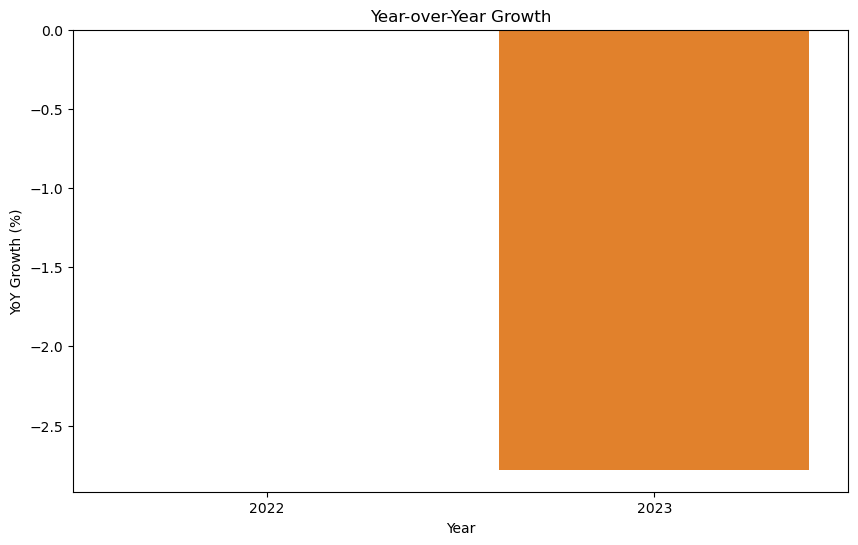

   year   placed_gmv  YoY_Growth
0  2022  88093090.95         NaN
1  2023  85644846.36   -2.779156


In [40]:
# Extract year from order_date
df['year'] = df['order_date'].dt.year

# Group by year to calculate total GMV per year
yearly_sales = df.groupby('year')['placed_gmv'].sum().reset_index()

# Calculate Year-over-Year Growth
yearly_sales['YoY_Growth'] = yearly_sales['placed_gmv'].pct_change() * 100

# Plotting Year-over-Year Growth
plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='YoY_Growth', data=yearly_sales)
plt.title('Year-over-Year Growth')
plt.xlabel('Year')
plt.ylabel('YoY Growth (%)')
plt.show()

# Display the Year-over-Year growth table
print(yearly_sales)


## 4. Analyze Average Order Value (AOV) Trends
We can calculate AOV (Average Order Value) by dividing the total GMV by the number of orders for a given time period.

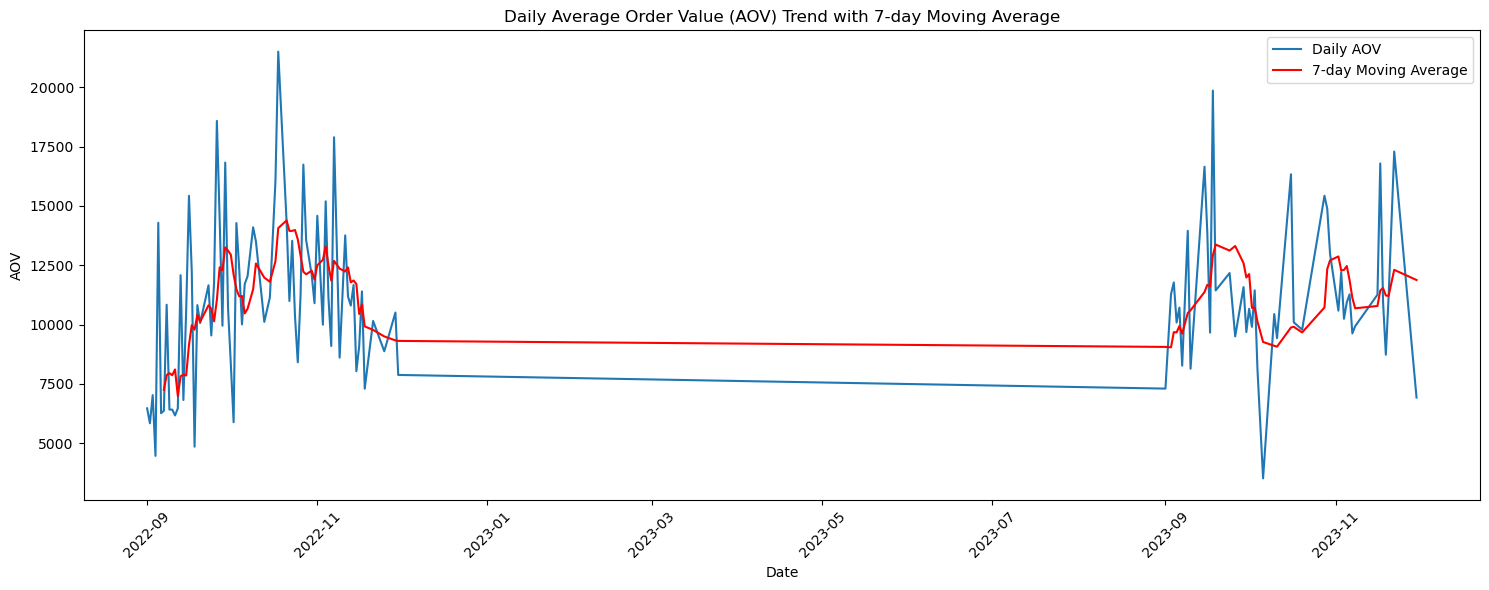

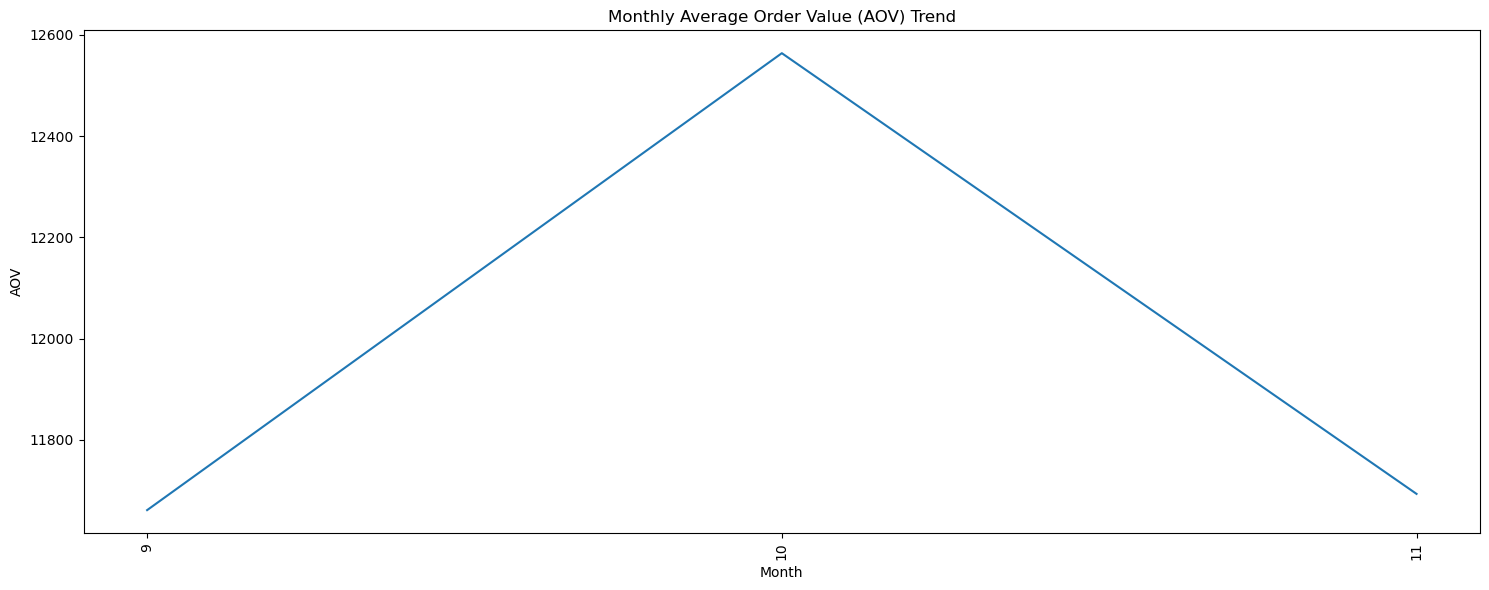

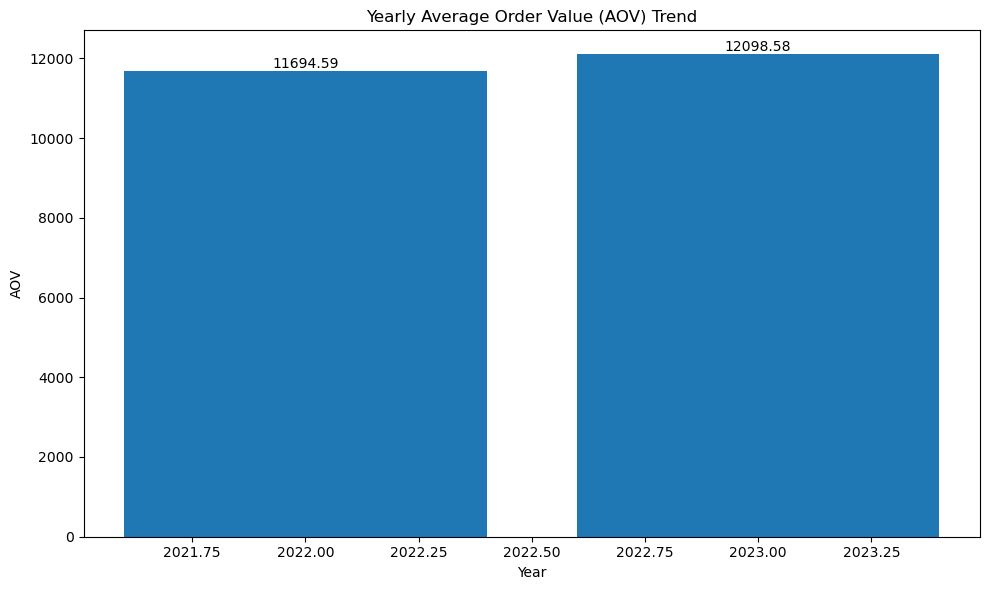

AOV Summary Statistics:
count    130000.000000
mean      11932.360900
std       14579.449841
min         103.500000
25%        3592.280000
50%        7115.310000
75%       15052.040000
max      225107.400000
Name: AOV, dtype: float64

Correlation between daily AOV and total sales: 0.70


In [41]:

# 4. Analyze average order value (AOV) trends
# Calculate AOV
df['AOV'] = df.groupby('order_id')['placed_gmv'].transform('sum')

# Daily AOV trend
daily_aov = df.groupby('order_date')['AOV'].mean().reset_index()
daily_aov['7_day_MA'] = daily_aov['AOV'].rolling(window=7).mean()

plt.figure(figsize=(15, 6))
plt.plot(daily_aov['order_date'], daily_aov['AOV'], label='Daily AOV')
plt.plot(daily_aov['order_date'], daily_aov['7_day_MA'], label='7-day Moving Average', color='red')
plt.title('Daily Average Order Value (AOV) Trend with 7-day Moving Average')
plt.xlabel('Date')
plt.ylabel('AOV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Monthly AOV trend
monthly_aov = df.groupby('Month')['AOV'].mean().reset_index()
monthly_aov['Month'] = monthly_aov['Month'].astype(str)

plt.figure(figsize=(15, 6))
plt.plot(monthly_aov['Month'], monthly_aov['AOV'])
plt.title('Monthly Average Order Value (AOV) Trend')
plt.xlabel('Month')
plt.ylabel('AOV')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Yearly AOV trend
yearly_aov = df.groupby('Year')['AOV'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(yearly_aov['Year'], yearly_aov['AOV'])
plt.title('Yearly Average Order Value (AOV) Trend')
plt.xlabel('Year')
plt.ylabel('AOV')
for i, v in enumerate(yearly_aov['AOV']):
    plt.text(yearly_aov['Year'][i], v, f'{v:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

print("AOV Summary Statistics:")
print(df['AOV'].describe())

# Calculate correlation between AOV and total daily sales
aov_sales_corr = daily_aov.merge(daily_sales, on='order_date')
correlation = aov_sales_corr['AOV'].corr(aov_sales_corr['placed_gmv'])
print(f"\nCorrelation between daily AOV and total sales: {correlation:.2f}")

# 4. SKU Performance Analysis

Identify top-selling SKUs by quantity and GMV
Analyze SKU diversity in orders
Perform ABC analysis to categorize SKUs
Examine SKU purchase patterns and correlations

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules

Identify top-selling SKUs by quantity and GMV:

Creates bar plots for top 10 SKUs by quantity and GMV
Prints the top 10 SKUs for each metric


Analyze SKU diversity in orders:

Calculates the number of unique SKUs per order
Plots the distribution of unique SKUs per order
Prints summary statistics for SKU diversity


Perform ABC analysis to categorize SKUs:

Categorizes SKUs into A, B, and C categories based on cumulative GMV
Plots the cumulative curve for ABC analysis
Prints the number and percentage of SKUs in each category

Examine SKU purchase patterns and correlations:
4.1 Time-based analysis:
- Plots monthly sales trends for top 5 SKUs
4.2 Correlation analysis:
- Creates a correlation heatmap for SKUs
- Prints top 10 correlated SKU pairs
4.3 Market Basket Analysis:
- Performs association rule mining
- Prints top 10 association rules
4.4 SKU Performance over time:
- Calculates and plots top 10 SKUs by average yearly growth rate
4.5 SKU Seasonality:
- Detects seasonality for each SKU
- Plots and prints top 10 SKUs by seasonality score
4.6 SKU Price Analysis:
- Calculates price variability for each SKU
- Plots and prints top 10 SKUs by price variability
4.7 SKU Performance by Customer Segment:
- Segments customers into low, medium, and high value
- Creates a heatmap of SKU performance by customer segment
- Prints top 5 SKUs for each customer segment

## 1. Identify top-selling SKUs by quantity and GMV

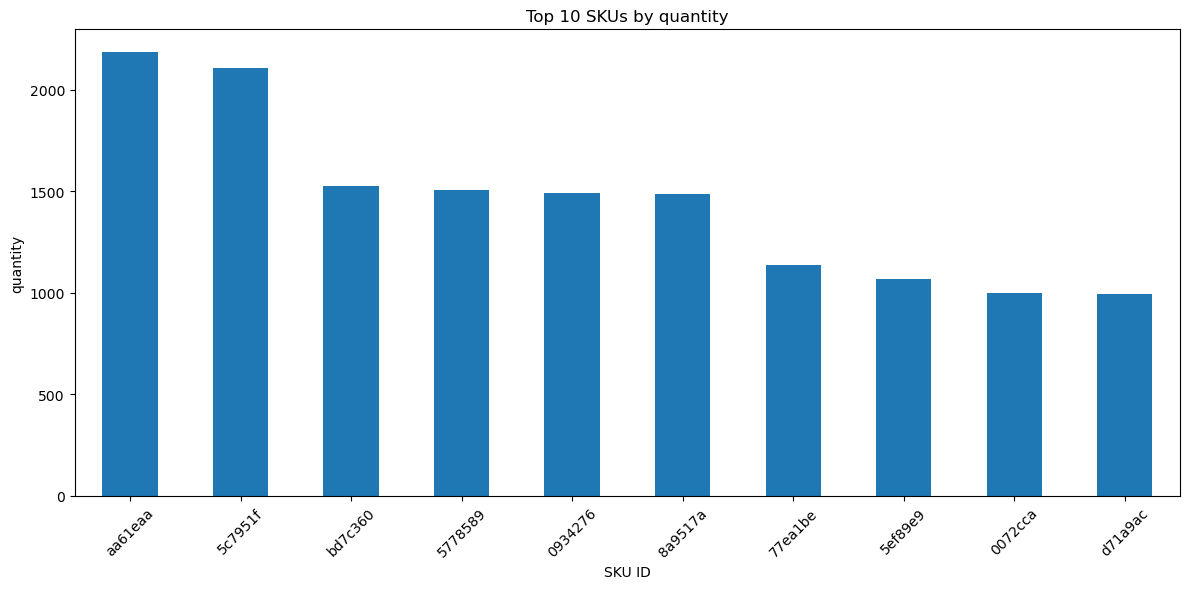


Top 10 SKUs by quantity:
sku_id
aa61eaa    2187.0
5c7951f    2108.0
bd7c360    1525.0
5778589    1504.0
0934276    1492.0
8a9517a    1486.0
77ea1be    1134.0
5ef89e9    1066.0
0072cca    1001.0
d71a9ac     994.0
Name: quantity, dtype: float64


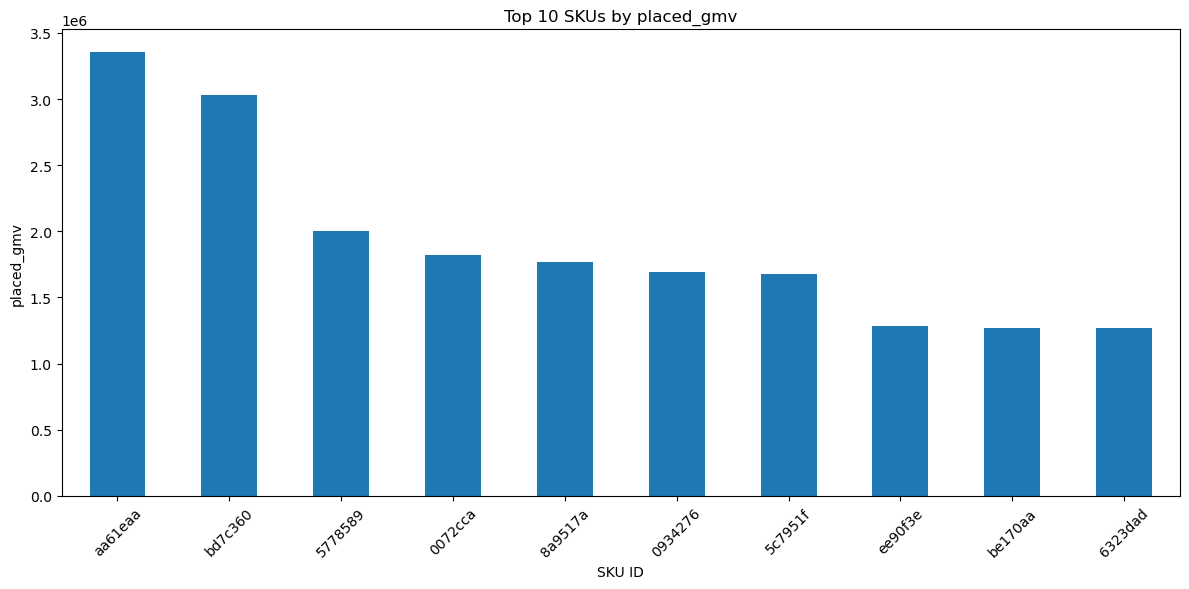


Top 10 SKUs by placed_gmv:
sku_id
aa61eaa    3358729.54
bd7c360    3033729.76
5778589    2004186.77
0072cca    1818349.65
8a9517a    1770669.35
0934276    1691484.70
5c7951f    1674269.10
ee90f3e    1285239.63
be170aa    1270098.64
6323dad    1269127.86
Name: placed_gmv, dtype: float64


In [43]:

def analyze_top_skus(df, metric, top_n=10):
    top_skus = df.groupby('sku_id')[metric].sum().sort_values(ascending=False).head(top_n)
    
    plt.figure(figsize=(12, 6))
    top_skus.plot(kind='bar')
    plt.title(f'Top {top_n} SKUs by {metric}')
    plt.xlabel('SKU ID')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"\nTop {top_n} SKUs by {metric}:")
    print(top_skus)

analyze_top_skus(df, 'quantity')
analyze_top_skus(df, 'placed_gmv')

## 2. Analyze SKU diversity in orders

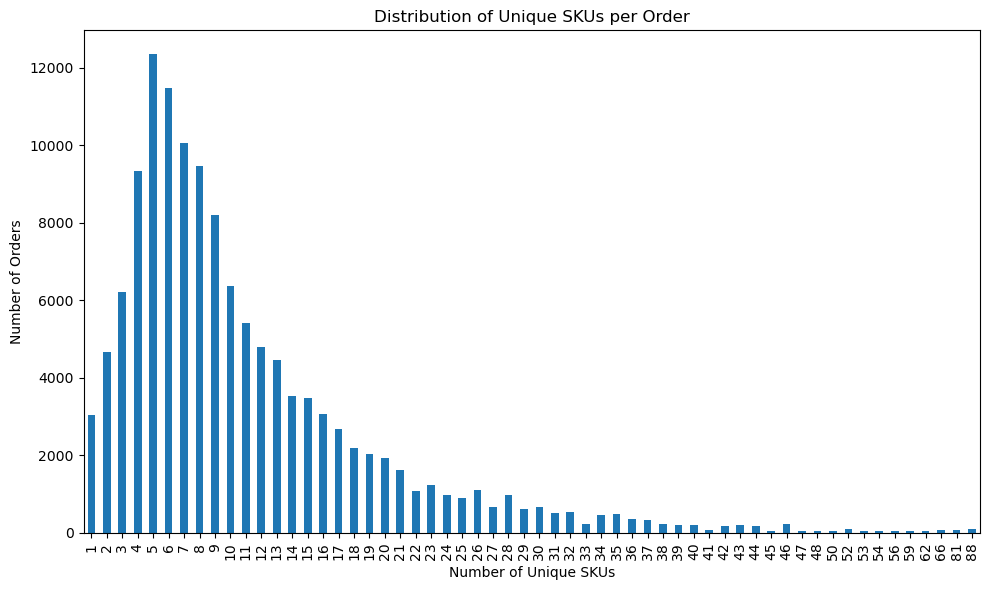


SKU Diversity Statistics:
count    130000.000000
mean         10.993162
std           8.917030
min           1.000000
25%           5.000000
50%           8.000000
75%          14.000000
max          88.000000
Name: unique_skus, dtype: float64


In [44]:

df['unique_skus'] = df.groupby('order_id')['sku_id'].transform('nunique')

plt.figure(figsize=(10, 6))
df['unique_skus'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Unique SKUs per Order')
plt.xlabel('Number of Unique SKUs')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

print("\nSKU Diversity Statistics:")
print(df['unique_skus'].describe())

## 3. Perform ABC analysis to categorize SKUs

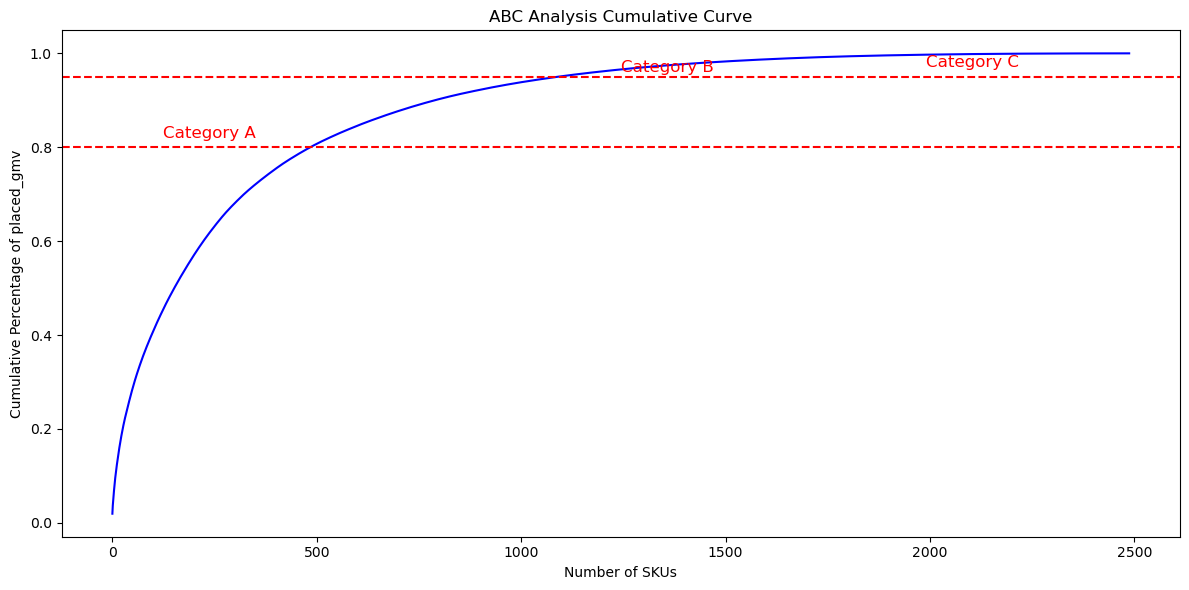


ABC Analysis Results:
placed_gmv
A     484
B     605
C    1398
Name: count, dtype: int64

Percentage of SKUs in each category:
placed_gmv
A    19.453376
B    24.316720
C    56.189711
Name: count, dtype: float64


In [45]:

def abc_analysis(df, value_column):
    sku_total = df.groupby('sku_id')[value_column].sum().sort_values(ascending=False)
    sku_total_cum = sku_total.cumsum() / sku_total.sum()
    
    sku_categories = pd.cut(sku_total_cum, bins=[0, 0.8, 0.95, 1], labels=['A', 'B', 'C'])
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(sku_total_cum)), sku_total_cum, 'b-')
    plt.title('ABC Analysis Cumulative Curve')
    plt.xlabel('Number of SKUs')
    plt.ylabel('Cumulative Percentage of ' + value_column)
    plt.axhline(y=0.8, color='r', linestyle='--')
    plt.axhline(y=0.95, color='r', linestyle='--')
    plt.text(len(sku_total_cum)*0.05, 0.82, 'Category A', fontsize=12, color='red')
    plt.text(len(sku_total_cum)*0.5, 0.96, 'Category B', fontsize=12, color='red')
    plt.text(len(sku_total_cum)*0.8, 0.97, 'Category C', fontsize=12, color='red')
    plt.tight_layout()
    plt.show()
    
    category_counts = sku_categories.value_counts().sort_index()
    print("\nABC Analysis Results:")
    print(category_counts)
    print("\nPercentage of SKUs in each category:")
    print(category_counts / len(sku_categories) * 100)
    
    return sku_categories

sku_categories = abc_analysis(df, 'placed_gmv')

## 4. Another analysis

### 4.1 Time-based analysis

<Figure size 1500x800 with 0 Axes>

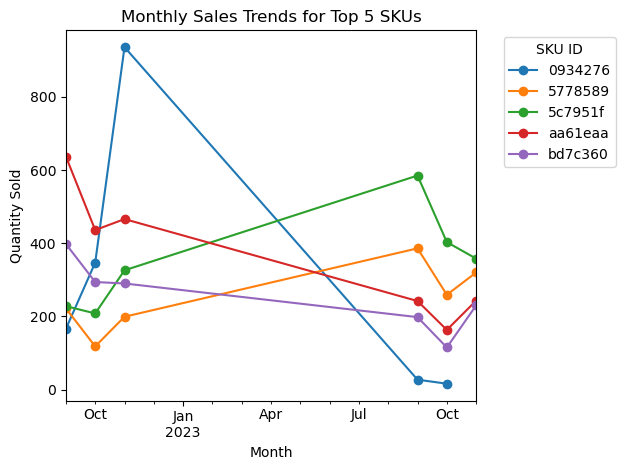

In [46]:
# 4. Examine SKU purchase patterns and correlations

df['order_date'] = pd.to_datetime(df['order_date'])
df['month'] = df['order_date'].dt.to_period('M')

top_5_skus = df.groupby('sku_id')['quantity'].sum().nlargest(5).index

sku_monthly_sales = df[df['sku_id'].isin(top_5_skus)].groupby(['month', 'sku_id'])['quantity'].sum().unstack()

plt.figure(figsize=(15, 8))
sku_monthly_sales.plot(marker='o')
plt.title('Monthly Sales Trends for Top 5 SKUs')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.legend(title='SKU ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 4.2 Correlation analysis

In [47]:

sku_correlation = df.pivot_table(values='quantity', index='order_id', columns='sku_id', aggfunc='sum', fill_value=0)
correlation_matrix = sku_correlation.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('SKU Correlation Heatmap')
plt.tight_layout()
plt.show()

# Find top correlated pairs
corr_unstack = correlation_matrix.unstack()
top_corr = corr_unstack[corr_unstack < 1].nlargest(10)

print("\nTop 10 Correlated SKU Pairs:")
print(top_corr)


In [48]:
corr_unstack = correlation_matrix.unstack()
top_corr = corr_unstack[corr_unstack < 1].nlargest(30)

print("\nTop 30 Correlated SKU Pairs:")
print(top_corr)


Top 30 Correlated SKU Pairs:
sku_id   sku_id 
320adaf  a6ae1cb    0.991596
a6ae1cb  320adaf    0.991596
320adaf  581e5e8    0.991561
581e5e8  320adaf    0.991561
         a6ae1cb    0.987324
a6ae1cb  581e5e8    0.987324
a2633d6  af6266b    0.979263
af6266b  a2633d6    0.979263
320adaf  ed18f1c    0.962180
ed18f1c  320adaf    0.962180
581e5e8  ed18f1c    0.961896
ed18f1c  581e5e8    0.961896
a6ae1cb  ed18f1c    0.957978
ed18f1c  a6ae1cb    0.957978
96371a7  bdd95ce    0.948679
bdd95ce  96371a7    0.948679
52cd9fa  b8918b2    0.943730
b8918b2  52cd9fa    0.943730
50f959b  56bd45d    0.912849
56bd45d  50f959b    0.912849
1e8fe4a  65e07a5    0.904533
65e07a5  1e8fe4a    0.904533
95f03a1  9c493b9    0.904533
9c493b9  95f03a1    0.904533
267cea2  ae83903    0.904533
ae83903  267cea2    0.904533
161f5fa  5cfe08c    0.894423
5cfe08c  161f5fa    0.894423
06f83e6  bdd95ce    0.894423
0dc5530  bdd95ce    0.894423
dtype: float64


In [50]:
# apriori is not defined how to reticify this error install and import
# !pip install mlxtend
from mlxtend.frequent_patterns import apriori, association_rules



### 4.3 Market Basket Analysis

In [51]:

def one_hot_encode(x):
    return 1 if x > 0 else 0

basket = df.groupby(['order_id', 'sku_id'])['quantity'].sum().unstack().applymap(one_hot_encode)

frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

print("\nTop 10 Association Rules:")
print(rules.sort_values('lift', ascending=False).head(10))



c:\Users\Ayush\apython\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Top 10 Association Rules:
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []


### 4.4 SKU Performance over time

In [ ]:
df['year'] = df['order_date'].dt.year
yearly_sku_performance = df.groupby(['year', 'sku_id'])['placed_gmv'].sum().unstack()

growth_rates = yearly_sku_performance.pct_change().mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
growth_rates.head(10).plot(kind='bar')
plt.title('Top 10 SKUs by Average Yearly Growth Rate')
plt.xlabel('SKU ID')
plt.ylabel('Average Yearly Growth Rate')
plt.tight_layout()
plt.show()

print("\nTop 10 SKUs by Average Yearly Growth Rate:")
print(growth_rates.head(10))


### 4.5 SKU Seasonality

In [53]:
#  import stats
from scipy import stats

In [54]:

def detect_seasonality(series):
    decomposition = stats.seasonal_decompose(series, model='additive', period=12)
    return decomposition.seasonal.abs().mean()

sku_seasonality = sku_monthly_sales.apply(detect_seasonality).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sku_seasonality.head(10).plot(kind='bar')
plt.title('Top 10 SKUs by Seasonality Score')
plt.xlabel('SKU ID')
plt.ylabel('Seasonality Score')
plt.tight_layout()
plt.show()

print("\nTop 10 SKUs by Seasonality Score:")
print(sku_seasonality.head(10))


AttributeError: module 'scipy.stats' has no attribute 'seasonal_decompose'

### 4.6 SKU Price Analysis

In [ ]:

df['unit_price'] = df['placed_gmv'] / df['quantity']

sku_price_stats = df.groupby('sku_id')['unit_price'].agg(['mean', 'min', 'max', 'std'])
sku_price_stats['coefficient_of_variation'] = sku_price_stats['std'] / sku_price_stats['mean']

plt.figure(figsize=(12, 6))
sku_price_stats.sort_values('coefficient_of_variation', ascending=False).head(10)['coefficient_of_variation'].plot(kind='bar')
plt.title('Top 10 SKUs by Price Variability')
plt.xlabel('SKU ID')
plt.ylabel('Coefficient of Variation')
plt.tight_layout()
plt.show()

print("\nTop 10 SKUs by Price Variability:")
print(sku_price_stats.sort_values('coefficient_of_variation', ascending=False).head(10))


### 4.7 SKU Performance by Customer Segment

In [ ]:

df['customer_segment'] = pd.qcut(df.groupby('user_id')['placed_gmv'].sum(), q=3, labels=['Low Value', 'Medium Value', 'High Value'])

segment_sku_performance = df.groupby(['customer_segment', 'sku_id'])['placed_gmv'].sum().unstack()
segment_sku_performance = segment_sku_performance.div(segment_sku_performance.sum(axis=1), axis=0)

plt.figure(figsize=(15, 8))
sns.heatmap(segment_sku_performance, annot=False, cmap='YlOrRd')
plt.title('SKU Performance by Customer Segment')
plt.tight_layout()
plt.show()

print("\nTop 5 SKUs for each Customer Segment:")
for segment in segment_sku_performance.index:
    print(f"\n{segment}:")
    print(segment_sku_performance.loc[segment].nlargest(5))

# Order analysis

## Now, let's break down the analysis for each part of the Order Analysis section using Python:

Analyze order sizes (number of items per order):

We start by calculating the total quantity for each order to get the number of items per order. Then we compute basic statistics using the describe() function, which gives us mean, median, min, max, and quartiles.
We also create a distribution of order sizes, showing the count and percentage of orders for each size. This is visualized using a histogram with a kernel density estimate (KDE) to show the overall shape of the distribution.
Key insights to look for:

The shape of the distribution (e.g., normal, skewed, bimodal)
The most common order size(s)
Any outliers in terms of extremely large orders


Examine the relationship between order size and GMV:

We analyze this relationship by:
a. Calculating the average GMV for each order size
b. Computing the correlation coefficient between order size and GMV
c. Creating a scatter plot to visualize the relationship
The average GMV per order size helps us understand how the order value changes as the number of items increases. The correlation coefficient gives us a single number (-1 to 1) indicating the strength and direction of the relationship.
Key insights to look for:

The trend in average GMV as order size increases
The strength of the correlation between order size and GMV
Any clusters or patterns in the scatter plot


Identify patterns in multi-item orders:

We explore multi-item orders from several angles:
a. Most common product combinations in multi-item orders
b. Comparison of average GMV for single-item vs multi-item orders
c. Seasonal patterns in orders
The product combinations analysis helps identify which products are frequently bought together. This information can be valuable for product recommendations and marketing strategies.
Comparing single-item and multi-item orders allows us to quantify the value of encouraging customers to add more items to their cart.
Seasonal patterns can reveal how order sizes and GMV change throughout the year. We visualize this with a line plot showing average items per order and average GMV for each month.
Key insights to look for:

Frequently co-purchased products
The difference in average GMV between single-item and multi-item orders
Months or seasons with higher or lower average order sizes and GMV

To get the most out of this analysis, you should run this Python code on your actual dataset and interpret the results in the context of your business. Look for unexpected patterns or trends that might inform business decisions, such as:

Pricing strategies (e.g., bundle discounts for frequently co-purchased items)
Marketing campaigns (e.g., focusing on increasing order sizes during months with typically smaller orders)
Product recommendations (based on common product combinations)
Customer segmentation (based on typical order sizes and values)

Basic statistics of order sizes:
count    21139.000000
mean         9.784332
std          9.483585
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max        212.000000
Name: items_per_order, dtype: float64

Distribution of order sizes:
items_per_order
1.0      6.338994
2.0      7.261460
3.0      7.072236
4.0      6.916127
5.0      7.814939
           ...   
147.0    0.004731
153.0    0.004731
157.0    0.004731
159.0    0.004731
212.0    0.004731
Name: count, Length: 100, dtype: float64


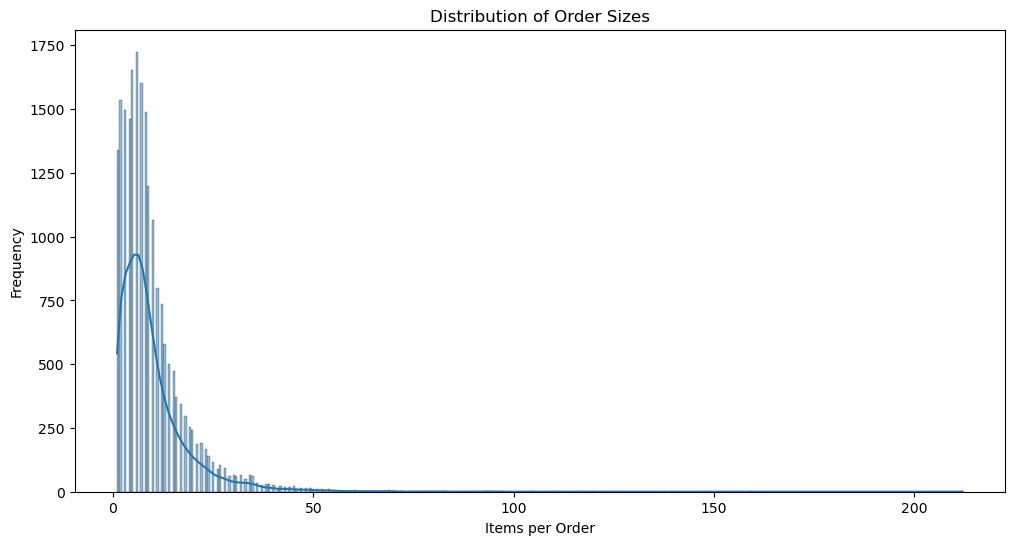


Average GMV by order size:
    items_per_order      total_gmv
0               1.0    3376.119590
1               2.0    3969.668248
2               3.0    4018.977017
3               4.0    4210.006826
4               5.0    5036.383487
..              ...            ...
95            147.0  185110.060000
96            153.0   25552.700000
97            157.0  119976.360000
98            159.0   46079.400000
99            212.0    3579.440000

[100 rows x 2 columns]

Correlation between order size and GMV: 0.60


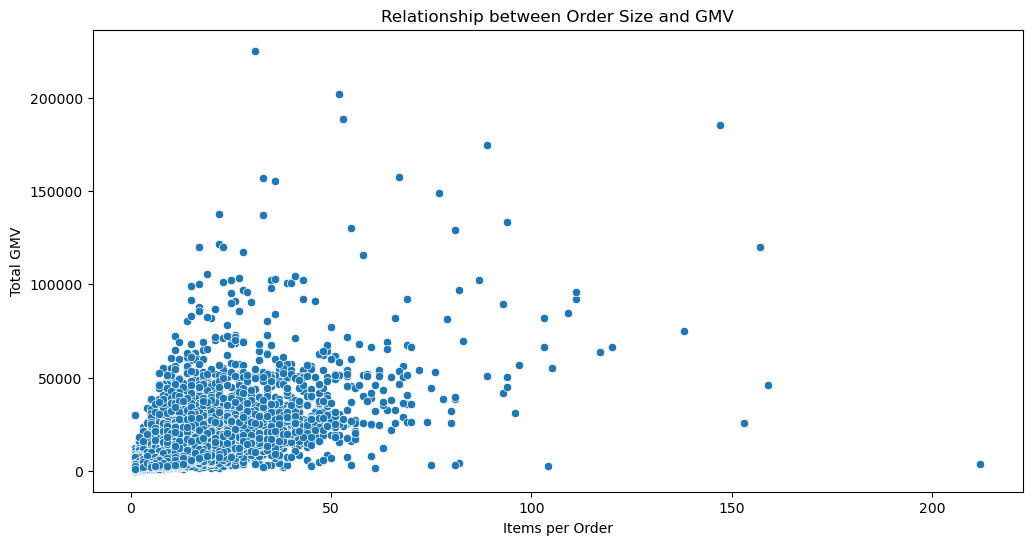


Most common product combinations in multi-item orders:
sku_id
(aa61eaa, bd7c360)             12
(0a2e89c, b267da9)             11
(0a2e89c, 7459b24, b267da9)     8
(0072cca, e8dfd5d)              8
(0072cca, fbf5862)              6
(8542e11, dc3fa4f)              6
(6b63af3, 9abc0db)              6
(0557dae, 2601a90)              6
(0934276, 56f9240)              5
(8ae416a, fe5f693)              5
Name: count, dtype: int64

Comparison of single-item vs multi-item orders:
                   avg_gmv  order_count
is_multi_item                          
False          3376.119590         1340
True           8546.590083        19799

Seasonal patterns in orders:
   month   quantity   placed_gmv
0      9   9.416080  7858.495579
1     10  10.319842  8699.902473
2     11   9.747356  8215.198914


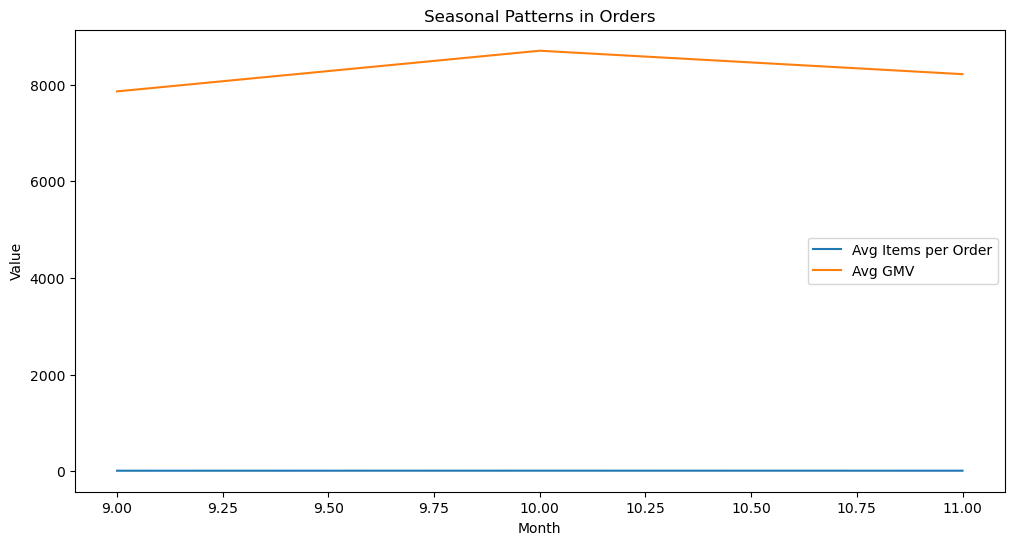

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming the data is already loaded into a DataFrame called 'df'
# df = pd.read_csv('order_dataset.csv')

# 1. Analyze order sizes (number of items per order)

# Calculate items per order
order_sizes = df.groupby('order_id')['quantity'].sum().reset_index(name='items_per_order')

# Basic statistics
basic_stats = order_sizes['items_per_order'].describe()
print("Basic statistics of order sizes:")
print(basic_stats)

# Distribution of order sizes
size_distribution = order_sizes['items_per_order'].value_counts().sort_index()
size_distribution_pct = size_distribution / len(order_sizes) * 100

print("\nDistribution of order sizes:")
print(size_distribution_pct)

# Visualization of order size distribution
plt.figure(figsize=(12, 6))
sns.histplot(order_sizes['items_per_order'], kde=True)
plt.title('Distribution of Order Sizes')
plt.xlabel('Items per Order')
plt.ylabel('Frequency')
plt.show()

# 2. Examine the relationship between order size and GMV

# Calculate total GMV per order
order_gmv = df.groupby('order_id')['placed_gmv'].sum().reset_index(name='total_gmv')

# Merge order sizes and GMV
order_summary = pd.merge(order_sizes, order_gmv, on='order_id')

# Calculate average GMV per order size
avg_gmv_by_size = order_summary.groupby('items_per_order')['total_gmv'].mean().reset_index()
print("\nAverage GMV by order size:")
print(avg_gmv_by_size)

# Correlation between order size and GMV
correlation = order_summary['items_per_order'].corr(order_summary['total_gmv'])
print(f"\nCorrelation between order size and GMV: {correlation:.2f}")

# Visualization of relationship between order size and GMV
plt.figure(figsize=(12, 6))
sns.scatterplot(data=order_summary, x='items_per_order', y='total_gmv')
plt.title('Relationship between Order Size and GMV')
plt.xlabel('Items per Order')
plt.ylabel('Total GMV')
plt.show()

# 3. Identify patterns in multi-item orders

# Identify multi-item orders
multi_item_orders = df.groupby('order_id')['sku_id'].nunique().reset_index(name='unique_items')
multi_item_orders = multi_item_orders[multi_item_orders['unique_items'] > 1]['order_id']

# Most common product combinations in multi-item orders
multi_item_df = df[df['order_id'].isin(multi_item_orders)]
combinations = multi_item_df.groupby('order_id')['sku_id'].apply(lambda x: tuple(sorted(x)))
common_combinations = combinations.value_counts().head(10)

print("\nMost common product combinations in multi-item orders:")
print(common_combinations)

# Compare single-item vs multi-item orders
order_summary['is_multi_item'] = order_summary['items_per_order'] > 1
single_vs_multi = order_summary.groupby('is_multi_item').agg({
    'total_gmv': 'mean',
    'order_id': 'count'
}).rename(columns={'total_gmv': 'avg_gmv', 'order_id': 'order_count'})

print("\nComparison of single-item vs multi-item orders:")
print(single_vs_multi)

# Seasonal patterns in multi-item orders
df['order_date'] = pd.to_datetime(df['order_date'])
df['month'] = df['order_date'].dt.month

seasonal_patterns = df.groupby(['order_id', 'month']).agg({
    'quantity': 'sum',
    'placed_gmv': 'sum'
}).reset_index()

seasonal_patterns = seasonal_patterns.groupby('month').agg({
    'quantity': 'mean',
    'placed_gmv': 'mean'
}).reset_index()

print("\nSeasonal patterns in orders:")
print(seasonal_patterns)

# Visualization of seasonal patterns
plt.figure(figsize=(12, 6))
sns.lineplot(data=seasonal_patterns, x='month', y='quantity', label='Avg Items per Order')
sns.lineplot(data=seasonal_patterns, x='month', y='placed_gmv', label='Avg GMV')
plt.title('Seasonal Patterns in Orders')
plt.xlabel('Month')
plt.ylabel('Value')
plt.legend()
plt.show()

## 3. Identify Patterns in Multi-Item Orders

### a. Analyze Percentage of Multi-Item Orders

In [133]:
# a. Analyze Percentage of Multi-Item Orders
order_item_count = df.groupby('order_id')['sku_id'].nunique().reset_index(name='unique_items')
multi_item_percentage = (order_item_count['unique_items'] > 1).mean() * 100

print(f"\nPercentage of multi-item orders: {multi_item_percentage:.2f}%")



Percentage of multi-item orders: 85.92%



GMV Contribution:
   is_multi_item  gmv_percentage
0          False        7.944571
1           True       92.055429


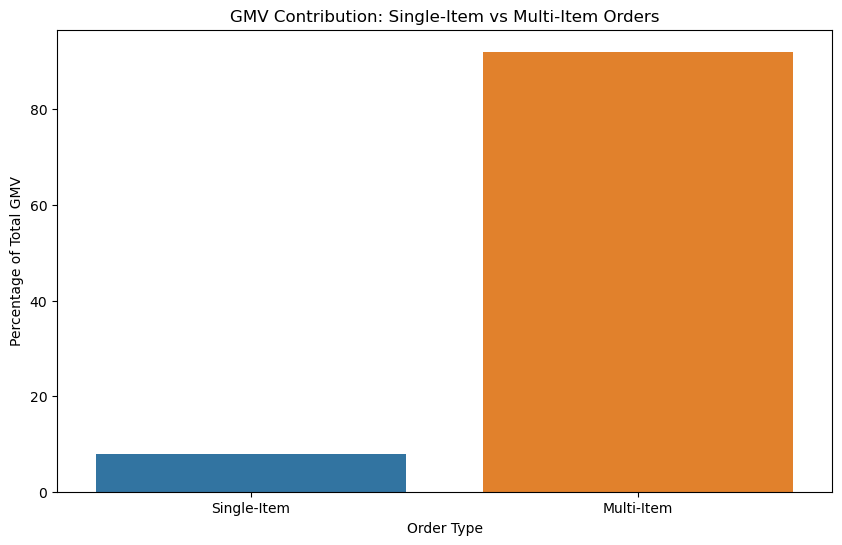

In [134]:

# b. Examine GMV Contribution from Multi-Item Orders
order_summary = df.groupby('order_id').agg({
    'sku_id': 'nunique',
    'placed_gmv': 'sum'
}).reset_index()

order_summary['is_multi_item'] = order_summary['sku_id'] > 1

gmv_contribution = order_summary.groupby('is_multi_item')['placed_gmv'].sum()
total_gmv = gmv_contribution.sum()
gmv_percentage = (gmv_contribution / total_gmv * 100).reset_index()
gmv_percentage.columns = ['is_multi_item', 'gmv_percentage']

print("\nGMV Contribution:")
print(gmv_percentage)

# Visualization of GMV Contribution
plt.figure(figsize=(10, 6))
sns.barplot(x='is_multi_item', y='gmv_percentage', data=gmv_percentage)
plt.title('GMV Contribution: Single-Item vs Multi-Item Orders')
plt.xlabel('Order Type')
plt.ylabel('Percentage of Total GMV')
plt.xticks([0, 1], ['Single-Item', 'Multi-Item'])
plt.show()


b. Weekly Sales Trends
We can use the resample function to aggregate the data into weekly time intervals.


Top 10 SKU pairs in multi-item orders:
(aa61eaa, bd7c360)    183
(0eeddec, 8705857)    159
(d0990b0, f4575a8)    143
(941d30b, cb91396)    137
(92e3cb7, d0990b0)    115
(8ae2033, 92e3cb7)    114
(0eeddec, 77ea1be)    110
(0934276, 56f9240)    104
(380b808, 5ef89e9)    103
(0085272, 385c311)     98
Name: count, dtype: int64


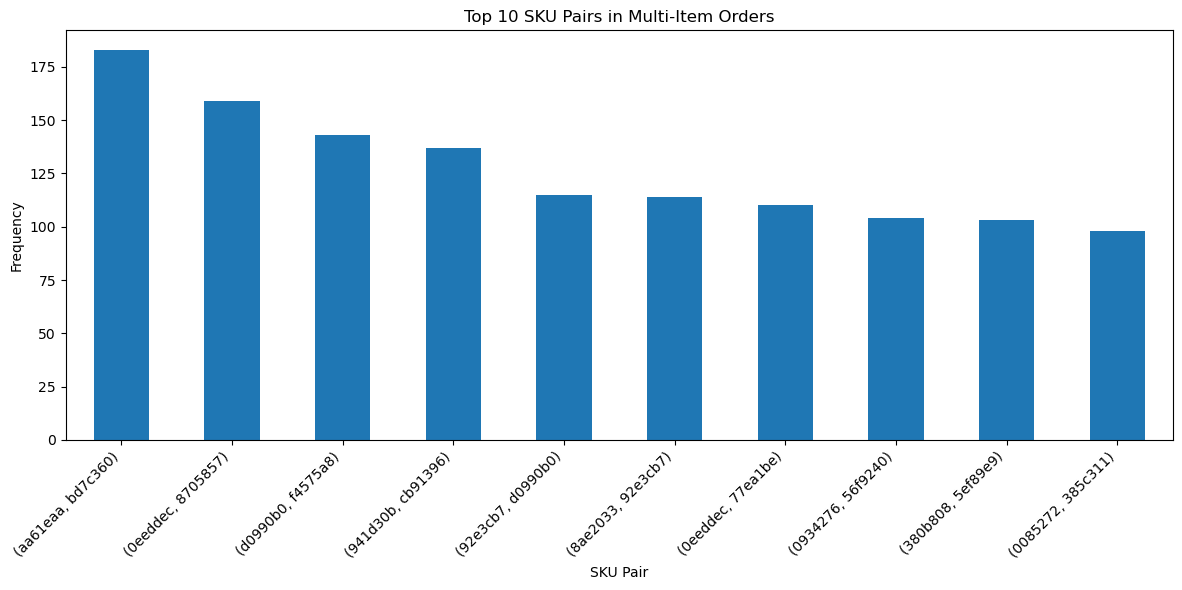

In [138]:
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt

# Filter multi-item orders
multi_item_orders = order_sizes[order_sizes['num_items'] > 1]['order_id']
multi_item_df = df[df['order_id'].isin(multi_item_orders)]

# Define the function to generate SKU pairs
def get_sku_pairs(group):
    skus = group['sku_id'].unique()
    skus_sorted = sorted(skus)  # Sort the SKUs before creating combinations
    return list(combinations(skus_sorted, 2))

# Apply the function to each order
sku_pairs = multi_item_df.groupby('order_id').apply(get_sku_pairs)

# Flatten the list of SKU pairs and count occurrences
sku_pair_counts = pd.Series([pair for pairs in sku_pairs for pair in pairs]).value_counts().head(10)

# Display top 10 SKU pairs in multi-item orders
print("\nTop 10 SKU pairs in multi-item orders:")
print(sku_pair_counts)

# Visualization of top SKU pairs
plt.figure(figsize=(12, 6))
sku_pair_counts.plot(kind='bar')
plt.title('Top 10 SKU Pairs in Multi-Item Orders')
plt.xlabel('SKU Pair')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



Value per Item Statistics:
count    130000.000000
mean        893.413491
std        1201.258420
min           4.200000
25%         324.330000
50%         458.400000
75%         847.650000
max       29700.000000
Name: value_per_item, dtype: float64

Top 10 SKUs by Average Value per Item:
sku_id
8ac18ce    14875.200000
2299b13     9790.000000
feea977     6119.280000
462be57     5920.620000
e9c02f4     4818.595556
2917e18     4359.360000
546ce3f     4256.000000
d4f6fc2     4181.153846
f526e88     4052.160000
b647ae4     3908.520000
Name: value_per_item, dtype: float64


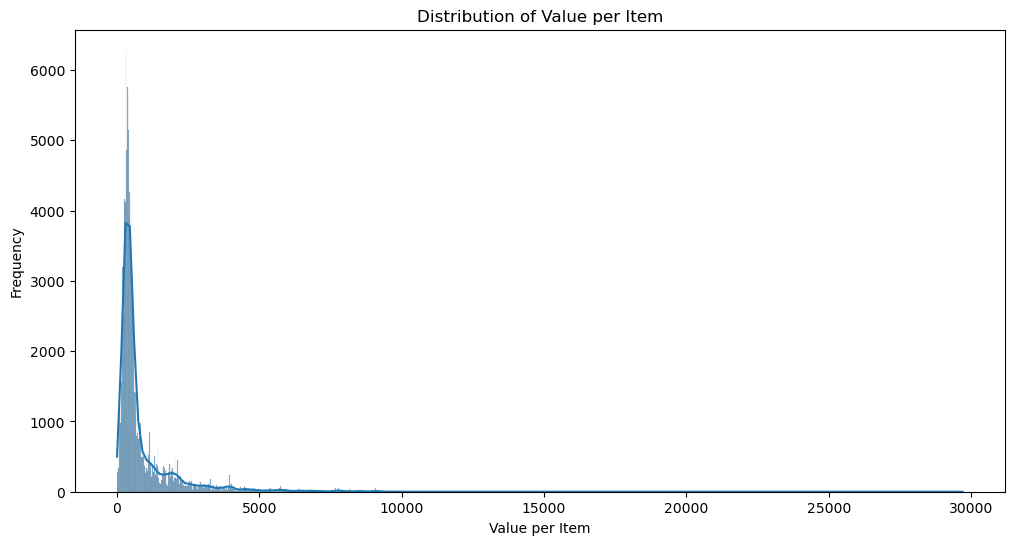


Average Value per Item: Single-Item vs Multi-Item Orders
is_multi_item
False    2378.160455
True      857.921765
Name: value_per_item, dtype: float64


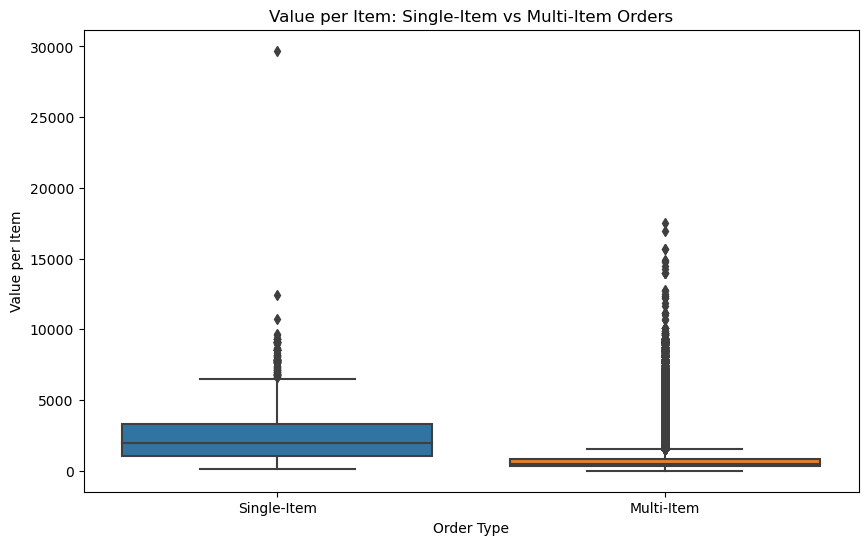

In [137]:

# 4. Analyze Order Value per Item
df['value_per_item'] = df['placed_gmv'] / df['quantity']

# Overall statistics of value per item
value_per_item_stats = df['value_per_item'].describe()
print("\nValue per Item Statistics:")
print(value_per_item_stats)

# Top 10 SKUs by average value per item
top_value_skus = df.groupby('sku_id')['value_per_item'].mean().sort_values(ascending=False).head(10)
print("\nTop 10 SKUs by Average Value per Item:")
print(top_value_skus)

# Visualization of value per item distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['value_per_item'], kde=True)
plt.title('Distribution of Value per Item')
plt.xlabel('Value per Item')
plt.ylabel('Frequency')
plt.show()

# Comparison of value per item in single-item vs multi-item orders
df['is_multi_item'] = df['order_id'].isin(multi_item_orders)
value_per_item_comparison = df.groupby('is_multi_item')['value_per_item'].mean()

print("\nAverage Value per Item: Single-Item vs Multi-Item Orders")
print(value_per_item_comparison)

# Visualization of value per item comparison
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_multi_item', y='value_per_item', data=df)
plt.title('Value per Item: Single-Item vs Multi-Item Orders')
plt.xlabel('Order Type')
plt.ylabel('Value per Item')
plt.xticks([0, 1], ['Single-Item', 'Multi-Item'])
plt.show()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df= pd.read_csv('data.csv')
df.head(5)

,Unnamed: 0,user_id,order_date,order_id,sku_id,warehouse_name,quantity,placed_gmv
0,0,0868733,2022-09-16,262052,2567941,USA,1.0,331.60
1,1,0868733,2022-09-16,262052,434572f,USA,1.0,416.52
2,2,0868733,2022-09-16,262052,8ae8fa4,USA,2.0,45.00
3,3,0868733,2022-09-16,262052,c9932dc,USA,3.0,67.50
4,4,0868733,2022-09-16,262052,35c7c3b,USA,1.0,340.71


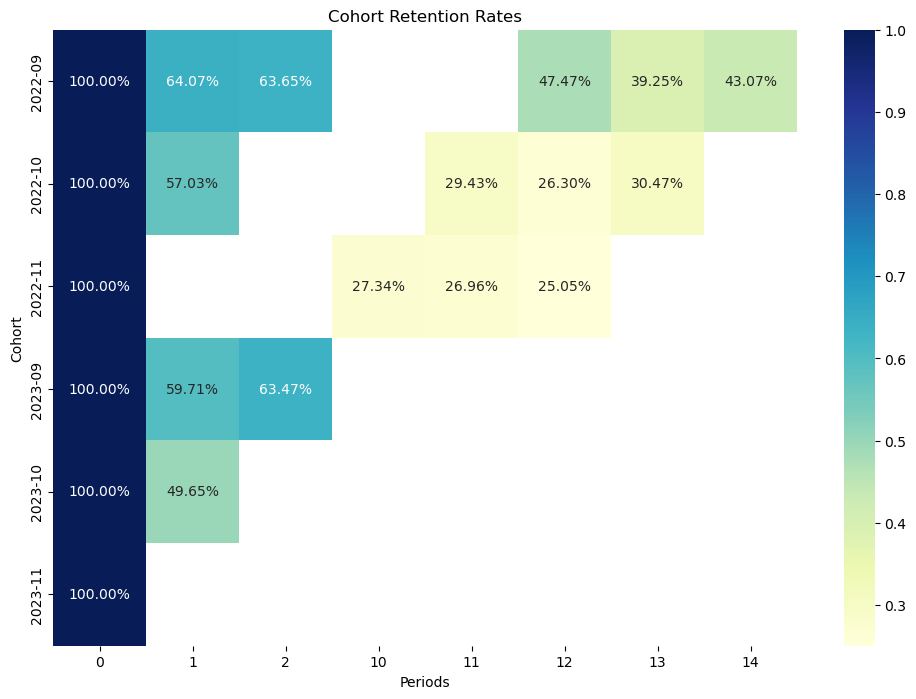

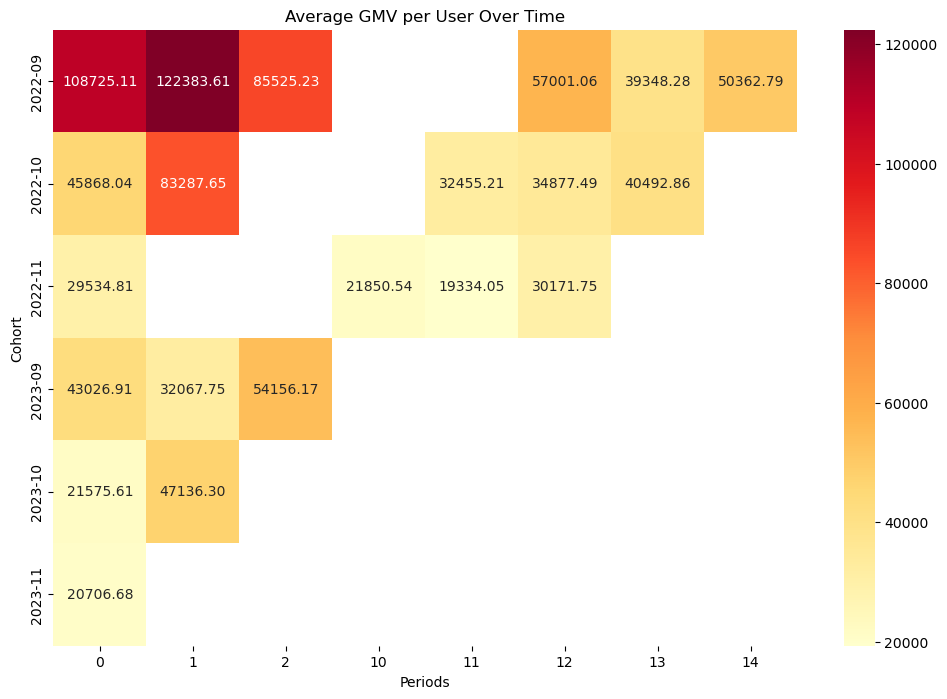

periods           0           1           2      10         11          12  \
count       6.000000    4.000000    2.000000    1.0    2.00000    3.000000   
mean      610.000000  426.500000  687.500000  143.0  127.00000  268.000000   
std       382.706676  296.630522  112.429978    NaN   19.79899  263.698692   
min       288.000000  143.000000  608.000000  143.0  113.00000  101.000000   
25%       322.500000  200.000000  647.750000  143.0  120.00000  116.000000   
50%       453.500000  395.500000  687.500000  143.0  127.00000  131.000000   
75%       849.250000  622.000000  727.250000  143.0  134.00000  351.500000   
max      1205.000000  772.000000  767.000000  143.0  141.00000  572.000000   

periods          13     14  
count      2.000000    1.0  
mean     295.000000  519.0  
std      251.730014    NaN  
min      117.000000  519.0  
25%      206.000000  519.0  
50%      295.000000  519.0  
75%      384.000000  519.0  
max      473.000000  519.0  

Retention Rates:
periods
0     1.00

In [3]:
df['order_date'] = pd.to_datetime(df['order_date'])

# Create cohorts based on the first purchase date of customers
df['cohort'] = df.groupby('user_id')['order_date'].transform('min').dt.to_period('M')

# Calculate the number of periods since first purchase
df['periods'] = (df['order_date'].dt.to_period('M') - df['cohort']).apply(lambda x: x.n)

# Create a cohort table
cohort_table = df.groupby(['cohort', 'periods']).agg({'user_id': pd.Series.nunique}).reset_index()
cohort_table = cohort_table.pivot(index='cohort', columns='periods', values='user_id')

# Calculate retention rates
cohort_sizes = cohort_table.iloc[:, 0]
retention_table = cohort_table.divide(cohort_sizes, axis=0)

# Plot the retention rates heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(retention_table, annot=True, cmap='YlGnBu', fmt='.2%')
plt.title('Cohort Retention Rates')
plt.xlabel('Periods')
plt.ylabel('Cohort')
plt.show()

# Analyze purchasing behavior
df['total_gmv'] = df['quantity'] * df['placed_gmv']
cohort_gmv = df.groupby(['cohort', 'periods'])['total_gmv'].sum().unstack()

# Plot average GMV per user over time
avg_gmv_per_user = cohort_gmv.divide(cohort_table)
plt.figure(figsize=(12, 8))
sns.heatmap(avg_gmv_per_user, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Average GMV per User Over Time')
plt.xlabel('Periods')
plt.ylabel('Cohort')
plt.show()

# Print summary statistics
print(cohort_table.describe())
print("\nRetention Rates:")
print(retention_table.mean())
print("\nAverage GMV per User:")
print(avg_gmv_per_user.mean())

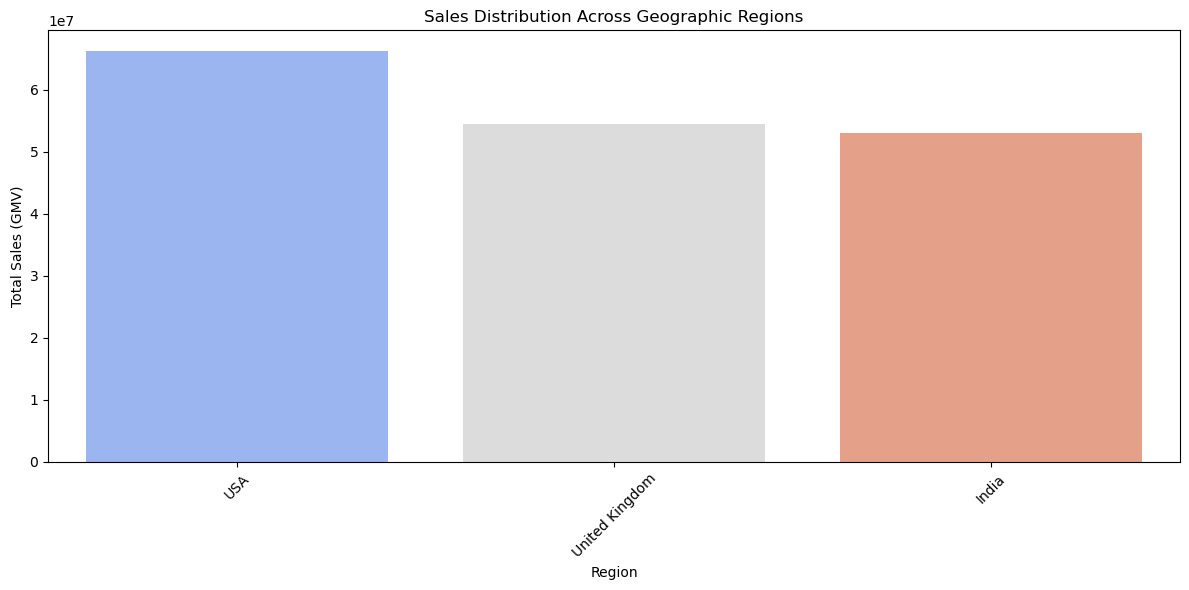

High-performing areas:
warehouse_name
USA    66248696.45
Name: placed_gmv, dtype: float64

Underperforming areas:
warehouse_name
United Kingdom    54423087.40
India             53066153.46
Name: placed_gmv, dtype: float64


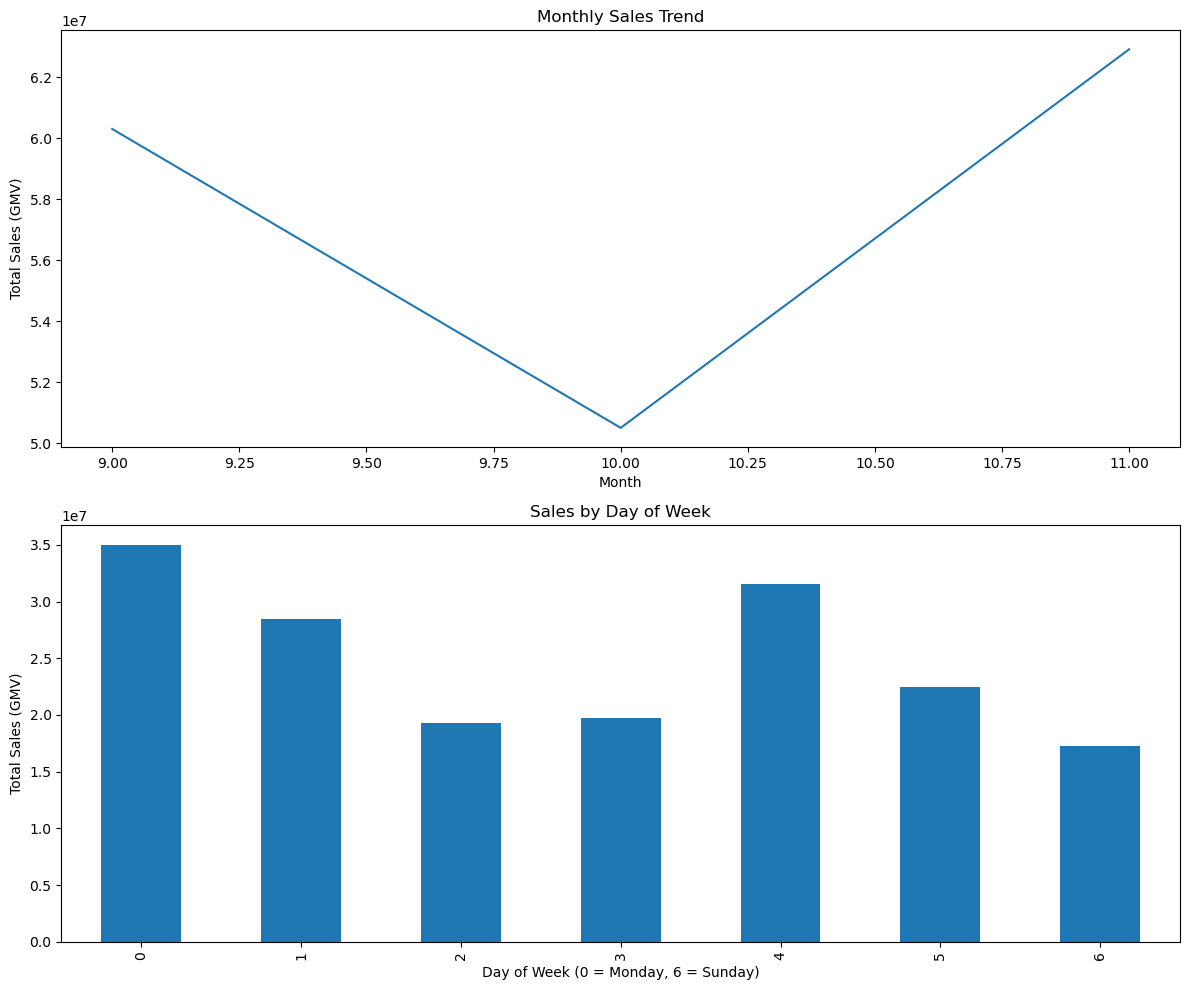

Potential promotion opportunities:
Months with below-average sales:
month
10    50511633.76
Name: placed_gmv, dtype: float64

Days of the week with below-average sales:
day_of_week
2    19264706.77
3    19741434.06
5    22500186.65
6    17285881.25
Name: placed_gmv, dtype: float64


In [6]:

# Geographical Analysis
def geographical_analysis(df):
    # Assuming 'warehouse_name' represents the geographic region
    geo_sales = df.groupby('warehouse_name')['placed_gmv'].sum().sort_values(ascending=False)
    
    # Visualize sales distribution
    plt.figure(figsize=(12, 6))
    sns.barplot(x=geo_sales.index, y=geo_sales.values,palette='coolwarm')
    plt.title('Sales Distribution Across Geographic Regions')
    plt.xlabel('Region')
    plt.ylabel('Total Sales (GMV)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Identify high-performing and underperforming areas
    avg_sales = geo_sales.mean()
    high_performing = geo_sales[geo_sales > avg_sales]
    low_performing = geo_sales[geo_sales < avg_sales]
    
    print("High-performing areas:")
    print(high_performing)
    print("\nUnderperforming areas:")
    print(low_performing)

# Time-based analysis for promotion opportunities
def promotion_opportunities(df):
    # Analyze sales by month and day of week
    df['month'] = df['order_date'].dt.month
    df['day_of_week'] = df['order_date'].dt.dayofweek
    
    monthly_sales = df.groupby('month')['placed_gmv'].sum()
    daily_sales = df.groupby('day_of_week')['placed_gmv'].sum()
    
    # Visualize monthly and daily sales trends
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    monthly_sales.plot(kind='line', ax=ax1)
    ax1.set_title('Monthly Sales Trend')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Total Sales (GMV)')
    
    daily_sales.plot(kind='bar', ax=ax2)
    ax2.set_title('Sales by Day of Week')
    ax2.set_xlabel('Day of Week (0 = Monday, 6 = Sunday)')
    ax2.set_ylabel('Total Sales (GMV)')
    
    plt.tight_layout()
    plt.show()
    
    # Identify potential promotion opportunities
    low_sales_months = monthly_sales[monthly_sales < monthly_sales.mean()]
    low_sales_days = daily_sales[daily_sales < daily_sales.mean()]
    
    print("Potential promotion opportunities:")
    print("Months with below-average sales:")
    print(low_sales_months)
    print("\nDays of the week with below-average sales:")
    print(low_sales_days)

# Run the analyses
geographical_analysis(df)
promotion_opportunities(df)

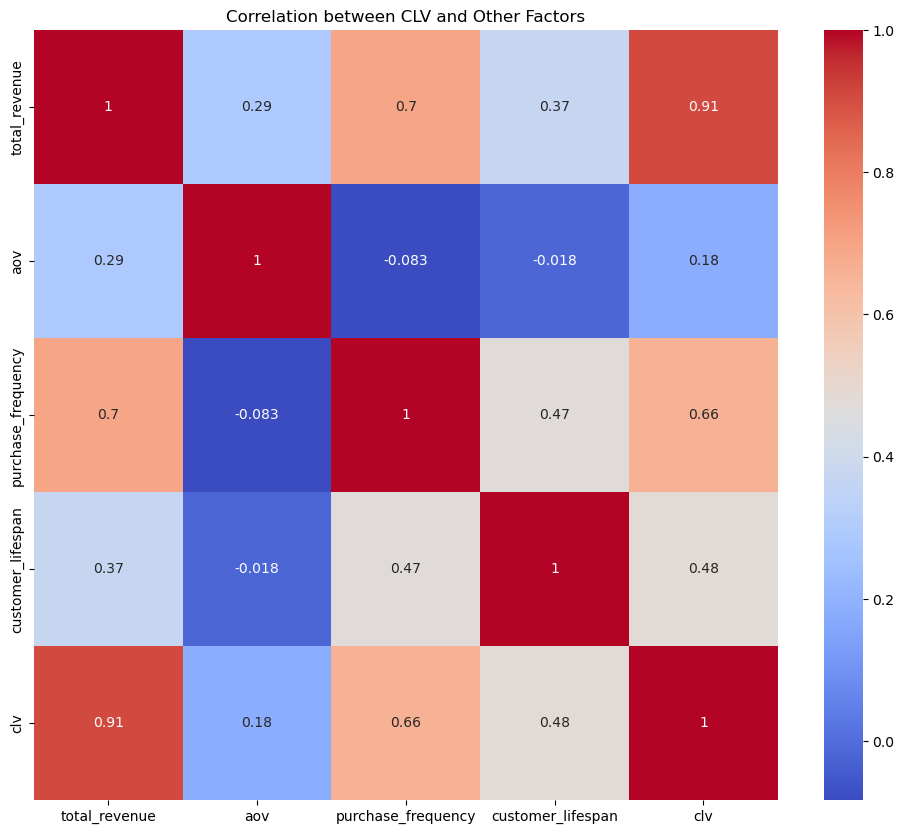

R-squared values for each factor:
total_revenue: 0.8246
aov: 0.0334
purchase_frequency: 0.4324
customer_lifespan: 0.2340

Most influential factor on CLV: total_revenue


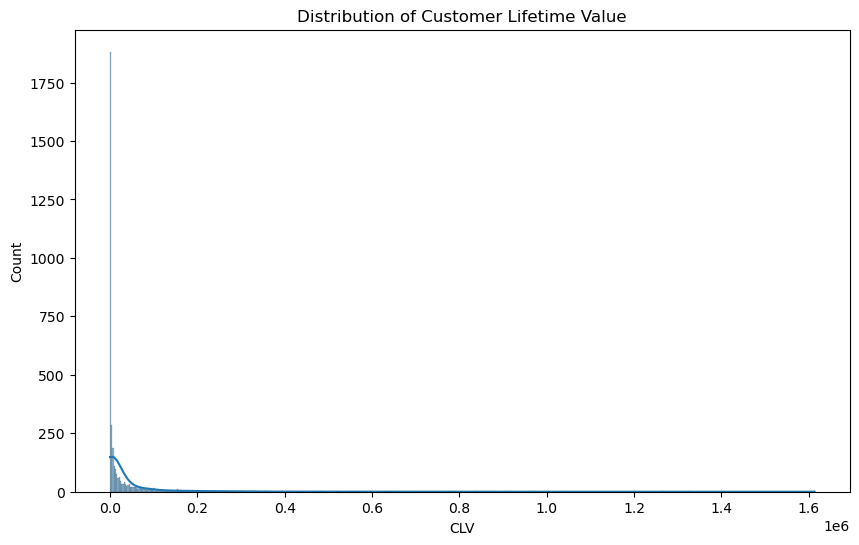


High-value customer segment characteristics:
       total_revenue           aov  purchase_frequency  customer_lifespan  \
count   9.150000e+02    915.000000          915.000000         915.000000   
mean    1.359013e+05   1892.196882           87.468852         374.959563   
std     1.633818e+05   1860.018535           78.594825         108.382506   
min     1.847519e+04    331.939577            5.000000          24.000000   
25%     4.312961e+04    710.465896           39.000000         377.000000   
50%     7.773364e+04   1267.571020           66.000000         416.000000   
75%     1.620621e+05   2304.871009          112.000000         433.000000   
max     1.332258e+06  14911.198246          833.000000         455.000000   

                clv  
count  9.150000e+02  
mean   1.327130e+05  
std    1.842984e+05  
min    2.188788e+04  
25%    3.969169e+04  
50%    6.934900e+04  
75%    1.466692e+05  
max    1.613310e+06  

Low-value customer segment characteristics:
       total_reve

In [7]:

from sklearn.linear_model import LinearRegression


def calculate_clv(df):
    # Calculate total revenue per customer
    customer_revenue = df.groupby('user_id')['placed_gmv'].sum()
    
    # Calculate average order value (AOV)
    aov = df.groupby('user_id')['placed_gmv'].mean()
    
    # Calculate purchase frequency (number of orders per customer)
    purchase_frequency = df.groupby('user_id').size()
    
    # Calculate customer lifespan (in days)
    customer_lifespan = df.groupby('user_id')['order_date'].agg(lambda x: (x.max() - x.min()).days)
    
    # Calculate CLV
    clv = customer_revenue * (customer_lifespan / 365)  # Assuming yearly CLV
    
    # Create a DataFrame with all customer metrics
    customer_metrics = pd.DataFrame({
        'total_revenue': customer_revenue,
        'aov': aov,
        'purchase_frequency': purchase_frequency,
        'customer_lifespan': customer_lifespan,
        'clv': clv
    })
    
    return customer_metrics

def analyze_clv_factors(customer_metrics):
    # Visualize correlation between CLV and other factors
    plt.figure(figsize=(12, 10))
    sns.heatmap(customer_metrics.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation between CLV and Other Factors')
    plt.show()
    
    # Perform simple linear regression to identify the most influential factor
    factors = ['total_revenue', 'aov', 'purchase_frequency', 'customer_lifespan']
    results = {}
    
    for factor in factors:
        X = customer_metrics[[factor]]
        y = customer_metrics['clv']
        model = LinearRegression().fit(X, y)
        results[factor] = model.score(X, y)
    
    # Print R-squared values
    print("R-squared values for each factor:")
    for factor, r_squared in results.items():
        print(f"{factor}: {r_squared:.4f}")
    
    # Identify the most influential factor
    most_influential = max(results, key=results.get)
    print(f"\nMost influential factor on CLV: {most_influential}")

# Calculate CLV and analyze factors
customer_metrics = calculate_clv(df)
analyze_clv_factors(customer_metrics)

# Visualize CLV distribution
plt.figure(figsize=(10, 6))
sns.histplot(customer_metrics['clv'], kde=True)
plt.title('Distribution of Customer Lifetime Value')
plt.xlabel('CLV')
plt.show()

# Identify high-value and low-value customer segments
high_value = customer_metrics[customer_metrics['clv'] > customer_metrics['clv'].quantile(0.75)]
low_value = customer_metrics[customer_metrics['clv'] < customer_metrics['clv'].quantile(0.25)]

print("\nHigh-value customer segment characteristics:")
print(high_value.describe())

print("\nLow-value customer segment characteristics:")
print(low_value.describe())

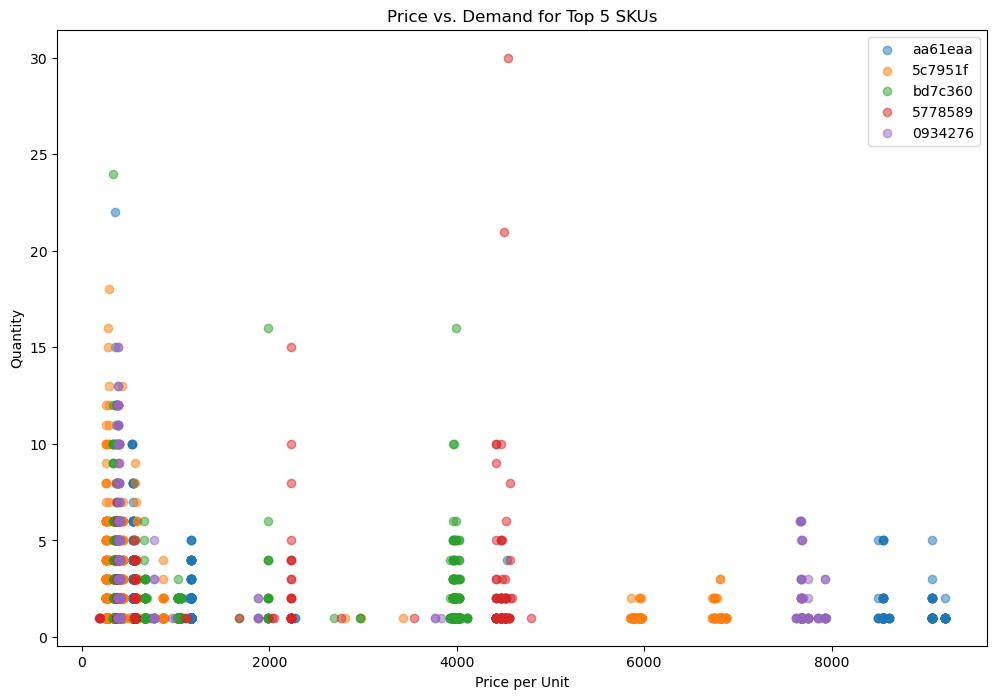

Price Optimization Opportunities:
       sku_id  elasticity                   optimization_opportunity
0     0015347         NaN  Positive elasticity - investigate further
1     006e5c9         0.0  Positive elasticity - investigate further
2     0072cca         NaN  Positive elasticity - investigate further
3     007b3d7         NaN  Positive elasticity - investigate further
4     0085272         NaN  Positive elasticity - investigate further
...       ...         ...                                        ...
2483  ff98043         NaN  Positive elasticity - investigate further
2484  ffb929c         NaN  Positive elasticity - investigate further
2485  ffba6c5         NaN  Positive elasticity - investigate further
2486  ffc1266         NaN  Positive elasticity - investigate further
2487  ffe93e4        -inf   Highly elastic - consider lowering price

[2488 rows x 3 columns]


MemoryError: Unable to allocate 1.97 EiB for an array with shape (283903669378570624,) and data type float64

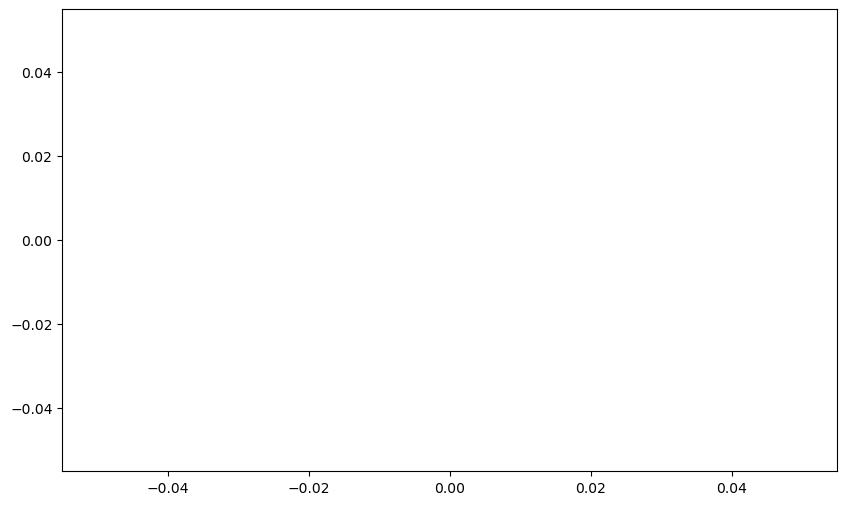

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def perform_price_sensitivity_analysis(df):
    # Calculate price per unit
    df['price_per_unit'] = df['placed_gmv'] / df['quantity']

    # Group by SKU and calculate average price and total demand
    sku_analysis = df.groupby('sku_id').agg({
        'price_per_unit': 'mean',
        'quantity': 'sum'
    }).reset_index()

    # Calculate price elasticity for each SKU
    def calculate_elasticity(group):
        price_pct_change = group['price_per_unit'].pct_change()
        demand_pct_change = group['quantity'].pct_change()
        elasticity = demand_pct_change / price_pct_change
        return elasticity.mean()

    elasticities = df.groupby('sku_id').apply(calculate_elasticity)
    sku_analysis['elasticity'] = sku_analysis['sku_id'].map(elasticities)

    # Visualize price vs. demand for top 5 SKUs by total quantity
    top_skus = sku_analysis.nlargest(5, 'quantity')
    plt.figure(figsize=(12, 8))
    for sku in top_skus['sku_id']:
        sku_data = df[df['sku_id'] == sku]
        plt.scatter(sku_data['price_per_unit'], sku_data['quantity'], alpha=0.5, label=sku)
    
    plt.xlabel('Price per Unit')
    plt.ylabel('Quantity')
    plt.title('Price vs. Demand for Top 5 SKUs')
    plt.legend()
    plt.show()

    # Identify price optimization opportunities
    def identify_optimization_opportunities(row):
        if row['elasticity'] < -1:
            return 'Highly elastic - consider lowering price'
        elif -1 <= row['elasticity'] < 0:
            return 'Inelastic - potential for price increase'
        else:
            return 'Positive elasticity - investigate further'

    sku_analysis['optimization_opportunity'] = sku_analysis.apply(identify_optimization_opportunities, axis=1)

    print("Price Optimization Opportunities:")
    print(sku_analysis[['sku_id', 'elasticity', 'optimization_opportunity']])

    # Visualize elasticity distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(sku_analysis['elasticity'], kde=True)
    plt.title('Distribution of Price Elasticity across SKUs')
    plt.xlabel('Price Elasticity')
    plt.show()

perform_price_sensitivity_analysis(df)